In [1]:
import pandas as pd

df1 = pd.read_csv("../clean_data_train/clean_mega.csv")
df2 = pd.read_csv("../clean_data_train/clean_cellphones.csv")

#Kiểm tra các cột chung
common_cols = df1.columns.intersection(df2.columns)
print("Các cột chung:", list(common_cols))

# Lọc hai DataFrame chỉ giữ lại các cột chung
df1_common = df1[common_cols]
df2_common = df2[common_cols]

# Gộp hai DataFrame lại với nhau theo chiều dòng
df = pd.concat([df1_common, df2_common], ignore_index=True)


# Xóa các ký tự không phải số và chuyển đổi sang kiểu float
df['Giá Bán'] = df['Giá Bán'].replace({r'[^\d]': ''}, regex=True).astype(float)

Các cột chung: ['Hãng Sản Xuất', 'Độ Dày', 'Trọng Lượng', 'CPU', 'RAM', 'Bộ Nhớ', 'GPU', 'Dung Lượng Pin', 'Hệ Điều Hành', 'Cổng Giao Tiếp', 'Màn Hình', 'Tên Sản Phẩm', 'Giá Bán']


In [2]:
def print_if_null(df, target_column, condition_column):
    """
    In ra các giá trị trong target_column nếu condition_column bị thiếu (NaN).
    
    Parameters:
        df (pd.DataFrame): DataFrame chứa dữ liệu
        target_column (str): Cột cần in giá trị
        condition_column (str): Cột dùng để kiểm tra giá trị thiếu (NaN)
    """
    null_rows = df[df[condition_column].isna()]
    print(null_rows[target_column].dropna().tolist())  # loại bỏ NaN nếu có trong target_column


In [3]:
#Chuyển đổi RAM thành số
import re

def extract_total_ram(ram_string):
    if not isinstance(ram_string, str):
        return None  # hoặc 0 nếu bạn muốn xem như không có RAM
    ram_string = ram_string.upper()

    # Trường hợp: "2 x 32GB", "2x16GB"
    match_multi = re.search(r'(\d+)\s*[xX]\s*(\d+)\s*GB', ram_string)
    if match_multi:
        count = int(match_multi.group(1))
        size = int(match_multi.group(2))
        return count * size

    # Trường hợp cộng nhiều thanh RAM như: "8GB (4GB + 4GB)"
    match_sum = re.findall(r'(\d+)\s*GB', ram_string)
    if match_sum:
        sizes = list(map(int, match_sum))
        return sum(sizes)

    # Trường hợp chỉ có một dung lượng: "16GB Onboard", "32GB LPDDR5x"
    match_single = re.search(r'(\d+)\s*GB', ram_string)
    if match_single:
        return int(match_single.group(1))

    return None
df['RAM'] = df['RAM'].apply(extract_total_ram)

In [5]:
import re
import numpy as np

# Từ điển mẫu tên laptop và RAM mặc định
ram_mapping = {
    r'LEGION 7': 32,
    r'HP 250': 8,
    r'NITRO 17': 16,
    r'INSPIRON 14': 16,
    r'VIVOBOOK 15': 8,
    r'VIVOBOOK X1404ZA': 8,
    r'VIVOBOOK X1502ZA': 8,
    r'TUF GAMING': 16,
    r'TUF A15': 16,
    r'ROG STRIX': 16,
    r'ROG ZEPHYRUS': 16,
    r'IDEAPAD 3': 8,
    r'IDEAPAD SLIM': 8,
    r'IDEAPAD SLIM': 16,
    r'THINKPAD E14': 16,
    r'THINKBOOK 14': 16,
    r'INSPIRON 15': 8,
    r'VOSTRO 15': 8,
    r'LATITUDE 34': 8,
    r'LATITUDE 54': 16,
    r'XPS 13': 16,
    r'MODERN 14': 8,
    r'GF63': 16,
    r'KATANA': 16,
    r'THIN GF63': 8,
    r'PAVILION 15': 8,
    r'VICTUS 15': 16,
    r'ELITEBOOK': 16,
    r'ENVY': 16,
    r'SPECTRE': 16,
    r'ASPIRE 3': 8,
    r'ASPIRE 5': 8,
    r'NITRO 5': 16,
    r'PREDATOR': 16,
    r'MACBOOK AIR': 8,
    r'MACBOOK PRO': 16,
    r'ROG STRIX': 16,
    r'LOQ 15IRX9': 16,
    r'THINKPAD E16': 16,
    r'VIVOBOOK 14': 8,
    r'LOQ 15IAX9E': 16,
    r'THINKPAD X13': 16,
    r'ELITEBOOK 840': 16,
    r'XPS 15': 32,
    r'TUF GAMING': 16,
    r'THINKPAD E16': 16,
    r'VIVOBOOK S': 8,
    r'PRESTIGE 13': 16,
    r'EXPERTBOOK B1': 8,
    r'ASPIRE LITE': 8,
    r'ZENBOOK DUO': 16,
    r'THINKPAD T14': 16,
    r'MODERN 15': 8,
    r'PRESTIGE 14': 16,
    r'XPS 14': 16,
    r'PROBOOK 460': 8,
    r'ASPIRE GO': 8,
    r'OMEN 16': 16,
    r'VIVOBOOK GO': 8,
    r'TUF GAMING': 16,
    r'VICTUS 16': 16,
    r'IDEAPAD 5': 16,
    r'PROBOOK 440': 8,
    r'INSPIRON 16': 8,
    r'NITRO V': 16,
    r'PROBOOK 450': 8,
    r'HP 240': 8,
    r'B1502CVA-NJ3405W': 8,
    r'INSPIRON 3520': 8,
    r'PROBOOK 460': 8,
    r'V15 G4': 8,
    r'THINKPAD E16': 16,
    r'PREDATOR HELIOS': 32,
    r'GAMING 5': 16,
    r'OMEN 15': 16,
    r'SPECTRE X360': 16,
    r'XPS 17': 32,
    r'ROG FLOW': 16,
    r'SWIFT 3': 8,
    r'ENVY X360': 16,
    r'ZENBOOK 14': 16,
    r'LEGION 5': 16,
    r'IDEAPAD FLEX': 8,
    r'VIVOBOOK FLIP': 8,
    r'EXPERTBOOK P1': 16,
    r'EXPERTBOOK P5': 16,
    r'EXPERTBOOK P1503CVA': 16,  
    r'ACER SWIFT': 16,
        r'HP 15': 8,
    r'DELL INSPIRON': 8,
    r'ASUS ZENBOOK': 16,
    r'DELL INSPIRON15': 8,
    r'LENOVO GAMING': 16,
    r'LENOVO LOQ': 16,
    r'DELL LATITUDE': 8,
        r'LENOVO THINKPAD': 16,
    r'LENOVO LEGION': 16,
    r'LENOVO LEGION5': 16,
    r'ASUS GAMING': 16,
        r'HP PAVILION': 8,
    r'HP 14-EP0110TU': 8,
    r'DELL GAMING': 16,
    r'MSI CREATOR': 16,
        r'HP 14-EP1009TU': 8,
    r'ASUS B1402CVA': 8,
    r'LENOVO YOGA': 16,
    r'ASUS TUF': 16,
    r'ASUS VIVOBOOK': 8,
        r'HP 14-EP1011TU': 8,
    r'HP ELITE': 16,
    r'ACER ASPIRE': 8,
    r'HP 14S-EP0112TU': 8,
    r'HP 14S-EP0128TU': 8,
    r'HP 14S-DQ5121TU': 8,
    r'HP 14S-DQ5122TU': 8,
       r'ACER GAMING': 16, 
        r'GAMING ACER': 16,
}


def map_ram_from_name(row):
    current_ram = row['RAM']
    name = row['Tên Sản Phẩm']
    
    # Nếu RAM đã có giá trị hợp lệ, giữ nguyên
    if not (pd.isna(current_ram) or current_ram == '' or current_ram == 0):
        return current_ram
    
    # Nếu tên sản phẩm không phải chuỗi thì trả NaN
    if not isinstance(name, str):
        return np.nan
    
    name_upper = name.upper()
    
    # Thử tìm RAM trực tiếp trong tên sản phẩm (ví dụ '16GB', '8 GB')
    match = re.search(r'(\d+)\s?GB', name_upper)
    if match:
        return int(match.group(1))
    
    # Nếu không có, thử ánh xạ theo mẫu tên laptop
    for pattern, ram in ram_mapping.items():
        if re.search(pattern, name_upper):
            return ram
    
    # Nếu không tìm được, trả NaN
    return np.nan
df['RAM'] = df.apply(map_ram_from_name, axis=1)
print(df['RAM'].unique())

[  8.  16.  32.  72.  48. 144.  56.  24. 384. 256.  96.  88.  80. 112.
 512.  64.  40. 192. 128.  nan   4.  12.  36.]


In [6]:
missing_count = df['RAM'].isna().sum()
print(f"Số giá trị thiếu trong cột 'RAM': {missing_count}")


Số giá trị thiếu trong cột 'RAM': 13


In [7]:
#Chuyển đổi PIN thành số
import pandas as pd
import re

# Hàm trích xuất dung lượng pin
def extract_battery_size(battery_string):
    if pd.isna(battery_string):
        return None
    battery_string = str(battery_string)  # Đảm bảo là chuỗi
    match = re.search(r'(\d+\.?\d*)\s*(Wh|Whrs|Whs|whr|wH)?', battery_string, re.IGNORECASE)
    if match:
        return float(match.group(1))
    return None

# Áp dụng chuẩn hóa cột Dung Lượng Pin
df['Dung Lượng Pin'] = df['Dung Lượng Pin'].apply(extract_battery_size)

# Tính giá trị trung bình cho các giá trị hợp lệ (≥ 10)
mean_valid_battery = df.loc[df['Dung Lượng Pin'] >= 10, 'Dung Lượng Pin'].mean()

# Thay thế các giá trị < 10 bằng giá trị trung bình hợp lệ
df.loc[df['Dung Lượng Pin'] < 10, 'Dung Lượng Pin'] = mean_valid_battery


In [8]:
import re
import numpy as np
import pandas as pd

import re
import numpy as np

# Dictionary mapping từ khóa (2 từ đầu sau "Laptop") sang dung lượng pin (Wh)
pin_mapping = {
    r'LENOVO THINKPAD': 57,
    r'ASUS ROG': 90,
    r'ASUS P1462CVA': 42,
    r'ACER ASPIRE': 48,
    r'MSI THIN': 56,
    r'MSI KATANA': 53,
    r'DELL XPS': 56,
    r'HP PROBOOK': 45,
    r'ASUS B1502CVA': 42,
    r'DELL INSPIRON': 42,
    r'LENOVO LOQ': 60,
    r'MSI MODERN': 42,
    r'LENOVO V14': 45,
    r'MAC MINI': 30,
    r'MACBOOK AIR': 35,
    r'IMAC M4': 50,
}

def map_pin_from_name(row):
    pin = row.get('Dung Lượng Pin')
    name = row.get('Tên Sản Phẩm', '')

    if pd.notna(pin) and pin not in [0, '']:
        return pin
    
    if not isinstance(name, str):
        return np.nan
    
    name_upper = name.upper()

    # Tìm dung lượng pin trực tiếp trong tên (vd: 56WH)
    m = re.search(r'(\d{2,3})\s?WH', name_upper)
    if m:
        return int(m.group(1))
    
    # Lấy 2 từ đầu sau "LAPTOP"
    parts = name_upper.split()
    key = ' '.join(parts[1:3]) if parts and parts[0] == 'LAPTOP' and len(parts) > 2 else ''
    
    for pattern, val in pin_mapping.items():
        if re.search(pattern, key):
            return val
    return np.nan


# Ví dụ dùng với dataframe df
df['Dung Lượng Pin'] = df.apply(map_pin_from_name, axis=1)
print(df['Dung Lượng Pin'].unique())

[ 61.15467172  60.          70.          54.8         53.
  57.          47.          90.          54.7         99.98
  45.          42.          99.9         48.          58.
  52.5         56.          71.          38.          63.
  72.          50.          75.          65.          73.
  56.6         41.          99.          99.99        80.
  52.          54.          76.          61.          40.
  62.          59.                  nan  18.          72.4
  84.          39.          37.         100.          39.3
  78.          55.          66.5       ]


In [9]:
missing_count = df['Dung Lượng Pin'].isna().sum()
print(f"Số giá trị thiếu trong cột 'PIn': {missing_count}")

Số giá trị thiếu trong cột 'PIn': 33


In [10]:
#Chuyển đổi CPU thành i3,i5,m3,m5,ryzen3.ryzen5,...
import re
import pandas as pd

def clean_string(s):
    # Loại bỏ dấu đặc biệt ® ™
    s = re.sub(r'[®™]', '', s)
    # Loại bỏ các dấu ngoặc và bên trong ngoặc
    s = re.sub(r'\(.*?\)', '', s)
    # Loại bỏ chữ số GHz, số cache, số lõi, thread,...
    s = re.sub(r'\d+(\.\d+)?\s*ghz', '', s)
    s = re.sub(r'\d+\s*mb', '', s)
    s = re.sub(r'\d+\s*(cores?|threads?|luồng|lõi|cache)', '', s)
    s = re.sub(r'[^\w\s-]', ' ', s)  # Thay các ký tự đặc biệt còn lại thành khoảng trắng
    s = re.sub(r'\s+', ' ', s)  # Chuẩn hóa khoảng trắng
    return s.strip().lower()

def extract_cpu_type(cpu_string):
    if pd.isna(cpu_string):
        return None

    s = clean_string(cpu_string)

    # Apple chip (m1,m2,m3,m4...)
    apple_match = re.search(r'\bm(\d+)\b', s)
    if 'apple' in s or apple_match:
        if apple_match:
            return f"M{apple_match.group(1).upper()}"
        else:
            return "Apple Unknown"
    
    # Ryzen
    ryzen_match = re.search(r'ryzen\s*(ai\s*)?r?(\d)', s)
    if ryzen_match:
        return f"Ryzen {ryzen_match.group(2)}"
    
    # Intel Core i3/i5/i7/i9
    intel_i_match = re.search(r'\b(i[3579])\b', s)
    if intel_i_match:
        return intel_i_match.group(1).upper()
    
    # Intel Core + số, ví dụ core 5, core 7
    intel_core_num_match = re.search(r'core\s*(?:i[3579])?[-\s]?(\d)', s)
    if intel_core_num_match:
        return f"Core {intel_core_num_match.group(1)}"
    
    # Core + số chung (dùng để bắt core 1, core 5...)
    core_num_match = re.search(r'core\s+(\d)', s)
    if core_num_match:
        return f"Core {core_num_match.group(1)}"

    # Ultra + số, có thể là Ultra U7-xxx, lấy số đầu tiên sau ultra
    ultra_match = re.search(r'ultra\s*[u]?(\d)', s)
    if ultra_match:
        return f"Ultra {ultra_match.group(1)}"
    
    # Snapdragon / Qualcomm
    if 'qualcomm' in s or 'snapdragon' in s:
        return 'Qualcomm Snapdragon'
    
    # AMD (nếu không rõ kiểu Ryzen)
    if 'amd' in s:
        return 'AMD'
    
    # Celeron (Intel thấp cấp)
    if 'celeron' in s:
        return 'Celeron'
    
    # Nếu không khớp
    return None



# Áp dụng cho cột CPU
df['Hãng CPU'] = df['CPU'].apply(extract_cpu_type)


In [11]:
cpu_mapping = {
    'LENOVO LEGION': 'Ryzen 7',
    'LENOVO THINKPAD': 'I7',
    'MSI PRESTIGE': 'I5',
    'DELL XPS': 'I9',
    'HP PROBOOK': 'I5',
    'LENOVO IDEAPAD': 'Ryzen 5',
    'ASUS B1502CVA': 'Core 5',
    'MACBOOK AIR': 'M3',
    'MAC MINI': 'M4',
    'ASUS TUF': 'Ryzen 9',
    'LENOVO V14': 'Core 5',
    'MSI MODERN': 'Core 7',
    'ASUS EXPERTBOOK': 'I5',
    'DELL LATITUDE': 'I3',
    'LENOVO LOQ': 'Ryzen 7',
    'ACER ASPIRE': 'Ryzen 5',
    'ACER ASPIRE LITE': 'Core 5',
    'SAMSUNG GALAXY': 'Qualcomm Snapdragon',
    'HP PAVILION': 'Ryzen 7',
    'DELL INSPIRON': 'Ryzen 5',
    
    # Mở rộng cho dòng Gaming và Creator mới
    'ASUS ROG': 'I9',                 # Gaming hiệu năng cao
    'ASUS GAMING': 'I7',             # Vivobook Gaming
    'ASUS VIVOBOOK': 'I5',           # Vẫn giữ mặc định dòng VivoBook thường
    'ACER GAMING': 'Ryzen 7',        # Dòng Acer Gaming
    'MSI CREATOR': 'I7',   
    'LENOVO GAMING': 'Ryzen 7',            # Laptop Lenovo gaming Legion
    'LENOVO YOGA': 'I7',                   # Dòng Yoga Slim đa phần dùng Core i7
    'ASUS ZENBOOK': 'I5', 
}

def map_cpu_if_gpu_empty(row):
    gpu = row.get('Hãng CPU', None)
    # Nếu 'Hãng GPU' không trống thì giữ nguyên (trả lại giá trị cũ)
    if pd.notna(gpu) and gpu != '':
        return row.get('Hãng CPU', None)  # hoặc giữ nguyên cột CPU Brand hiện tại
    
    # Nếu trống thì map CPU theo tên sản phẩm
    name = str(row.get('Tên Sản Phẩm', '')).upper()
    words = name.split()
    if len(words) >= 4 and words[0] == 'LAPTOP':
        key = ' '.join(words[1:4])
    elif len(words) >= 3 and words[0] == 'LAPTOP':
        key = ' '.join(words[1:3])
    else:
        key = ' '.join(words[:3])
    
    for k in cpu_mapping.keys():
        if k in key:
            return cpu_mapping[k]
    return None

# Áp dụng
df['Hãng CPU'] = df.apply(map_cpu_if_gpu_empty, axis=1)
print(df['Hãng CPU'].unique())

['I3' 'I5' 'Ultra 5' 'I7' 'Core 5' 'Core 1' 'Ultra 7' 'Ryzen 7' 'Ryzen 9'
 'I9' 'Ultra 9' 'Core 7' 'Qualcomm Snapdragon' 'Ryzen 5' None 'M3' 'M2'
 'M4' 'Celeron']


In [12]:
missing_count = df['Hãng CPU'].isna().sum()
print(f"Số giá trị thiếu trong cột: {missing_count}")

Số giá trị thiếu trong cột: 9


In [13]:
#Tách số Lõi
import re

def extract_cores(cpu_str):
    if not cpu_str or not isinstance(cpu_str, str):
        return None
    
    # 1. Tìm dạng (X lõi / Y luồng) hoặc X lõi / Y luồng
    match_lu_thread = re.search(r'(\d+)\s*lõi\s*/\s*\d+\s*luồng', cpu_str, re.I)
    if match_lu_thread:
        return int(match_lu_thread.group(1))
    
    # 2. Tìm tổng hợp P-core, E-core, LPE-core
    p_cores = sum(int(x) for x in re.findall(r'(\d+)\s*P[-\s]?core', cpu_str, re.I)) or 0
    e_cores = sum(int(x) for x in re.findall(r'(\d+)\s*E[-\s]?core', cpu_str, re.I)) or 0
    lpe_cores = sum(int(x) for x in re.findall(r'(\d+)\s*LPE[-\s]?core', cpu_str, re.I)) or 0
    total = p_cores + e_cores + lpe_cores
    if total > 0:
        return total
    
    # 3. Tìm dạng "X lõi"
    match_core_only = re.search(r'(\d+)\s*lõi', cpu_str, re.I)
    if match_core_only:
        return int(match_core_only.group(1))
    
    # 4. Tìm dạng "XC" hoặc "X C"
    match_c = re.search(r'(\d+)\s*C', cpu_str, re.I)
    if match_c:
        return int(match_c.group(1))
    
    # 5. Tìm dạng "X cores", "X core", "X nhân"
    match_core_words = re.search(r'(\d+)\s*(core|cores|nhân)', cpu_str, re.I)
    if match_core_words:
        return int(match_core_words.group(1))
    
    # --- Bắt đầu dự đoán số lõi nếu không tìm thấy rõ ---
    
    cpu_str_lower = cpu_str.lower()
    
    # 6. Dự đoán lõi cho Intel theo dòng và series
    # i9 thường 14-24 lõi (mình lấy trung bình 20)
    if 'i9' in cpu_str_lower:
        if 'hx' in cpu_str_lower:
            return 24  # thường 24 lõi (ví dụ 13900HX)
        elif 'h' in cpu_str_lower:
            return 14  # 14 lõi phổ biến H-series i9
        else:
            return 10  # các dòng i9 khác (U, G...)
    
    # i7 phổ biến 8-14 lõi
    if 'i7' in cpu_str_lower:
        if 'hx' in cpu_str_lower:
            return 16  # i7 HX series thường 16 lõi (vd 13650HX)
        elif 'h' in cpu_str_lower:
            return 14  # i7 H-series phổ biến 14 lõi (vd 13700H)
        elif 'u' in cpu_str_lower:
            return 10  # i7 U-series có thể 10 lõi (vd 13620U)
        else:
            return 8
    
    # i5 phổ biến 4-10 lõi
    if 'i5' in cpu_str_lower:
        if 'hx' in cpu_str_lower:
            return 12  # i5 HX thường 12 lõi
        elif 'h' in cpu_str_lower:
            return 8
        elif 'u' in cpu_str_lower:
            return 6
        else:
            return 4
    
    # i3 thường 2-4 lõi
    if 'i3' in cpu_str_lower:
        if 'h' in cpu_str_lower or 'hx' in cpu_str_lower:
            return 6
        else:
            return 4
    
    # Intel Ultra (Core Ultra 7/5...) thường 8-16 lõi, tính trung bình 12 lõi
    if 'ultra' in cpu_str_lower:
        return 12
    
    # AMD Ryzen 7 ~ 8 lõi, Ryzen 5 ~ 6 lõi, Ryzen 3 ~ 4 lõi
    if 'ryzen' in cpu_str_lower:
        if '7' in cpu_str_lower:
            return 8
        if '5' in cpu_str_lower:
            return 6
        if '3' in cpu_str_lower:
            return 4
    
    # AMD Ryzen AI 7 thường ~ 8 lõi
    if 'ryzen ai 7' in cpu_str_lower:
        return 8
    
    # Nếu có "core" nhưng không rõ, lấy 4 làm mặc định
    if 'core' in cpu_str_lower:
        return 4
    
    cpu_str_lower = cpu_str.lower()
    
    # Snapdragon (Qualcomm)
    if 'snapdragon' in cpu_str_lower:
        # Nếu tìm thấy số lõi dạng 'X lõi' thì ưu tiên dùng
        match_core = re.search(r'(\d+)\s*lõi', cpu_str_lower)
        if match_core:
            return int(match_core.group(1))
        
        # Nếu có số trong chuỗi, nhưng không rõ định dạng
        # Có thể thử lấy số cache hoặc số lớn nhất gần đó (tạm thời không)
        
        # Dự đoán theo dòng phổ biến:
        # Snapdragon cao cấp X Plus, X Elite thường 8 lõi
        if 'x plus' in cpu_str_lower or 'x elite' in cpu_str_lower:
            return 8
        
        # Nếu có X1E, X1P hoặc X1 thì giả định 8 lõi
        if 'x1e' in cpu_str_lower or 'x1p' in cpu_str_lower or 'x1' in cpu_str_lower:
            return 8
        
        # Mặc định Snapdragon khác lấy 8 lõi
        return 8

    # Không đoán được trả None
    return cpu_str


df['Số Lõi'] = df['CPU'].apply(extract_cores)
print(df['Số Lõi'].unique())

[12.  8.  3. 14.  4. 10.  6. nan 16. 24. 20.  5. 28.]


In [14]:
missing_count = df['Số Lõi'].isna().sum()
print(f"Số giá trị thiếu trong cột 'Số Lõi': {missing_count}")

Số giá trị thiếu trong cột 'Số Lõi': 163


In [15]:
#Tách xung nhịp tối đa
import re

def clean_cpu_string(cpu_str):
    if not cpu_str or not isinstance(cpu_str, str):
        return ""
    
    # Loại bỏ các ký tự đặc biệt như ™ ® ( ) [ ] dấu nháy đơn, kép,...
    cleaned = re.sub(r'[™®\(\)\[\]\'\"]', '', cpu_str)
    
    # Thay thế dấu gạch ngang dài/dạng Unicode thành dấu '-'
    cleaned = re.sub(r'[–—−]', '-', cleaned)
    
    # Thay nhiều khoảng trắng thành 1 khoảng trắng
    cleaned = re.sub(r'\s+', ' ', cleaned)
    
    # Xóa khoảng trắng đầu cuối
    cleaned = cleaned.strip()
    
    # Chuyển thành chữ thường
    cleaned = cleaned.lower()
    
    return cleaned

# Bảng tra cứu model CPU (có thể mở rộng thêm)
cpu_freq_lookup = {
    'intel core i5-12450h': 4.4,
    'intel core i5-13420h': 4.6,
    'intel core i9-14900hx': 5.4,
    'intel core ultra 5-125u': 4.7,
    'intel core i5-1334u': 4.5,
    'intel core i7-1355u': 5.0,
    'amd ryzen 9 hx 370': 4.8,
    'amd ryzen 7 7435hs': 4.3,
    'intel core ultra 7-155u': 5.2,
    'intel core i7-12650h': 4.7,
    'amd ryzen 7 6800h': 4.7,
    'intel core i5-1135g7': 4.2,
    'intel core i7-13620h': 5.0,
    'apple m2': 3.5,
    'apple m3 pro': 3.7,
    'apple m4 pro': 3.9,
    'amd ryzen ai 9 hx 370': 4.0,
    'amd ryzen 7 7435hs': 4.0,
    'intel core 7-150u': 5.0,
    'intel core i7-150u': 5.0,
    'intel core ultra 7 155h': 5.6,
    'intel core i7-1355u': 5.0,
    'intel core i5-1035g4': 3.7,
    'intel core i5-11320h': 4.4,
    'apple m3': 3.7,
    'intel core i3-n305': 3.0,
    'alder lake i5-12450h': 4.4,
    'intel core ultra u7-155h': 5.6,
    'apple m3 max': 3.9,
    'amd ryzen 7-5700u': 4.3,
    'intel core i5-1235u': 4.4,
    'amd ryzen r7-8845hs': 4.3,
    'intel core i5-1240p': 4.4,
    'core i5-1335u': 4.6,
    'intel core i7-14650hx': 5.4,
    'core i7-13700h': 5.4,
    'intel core i5-1135g7': 4.2,
    'intel core i5 tiger lake - 1135g7': 4.2,
    'amd ryzen ai 9 hx 370': 4.0,
    'amd ryzen 7 7435hs': 4.0,
    'intel core 7-150u': 5.0,
    'intel core i7-150u': 5.0,
    'intel core ultra 7 155h': 5.6,
    'intel core i7-1355u': 5.0,
    'intel core i5-1035g4': 4.1,
    'intel core i5-1135g7': 4.2,
    'core 7-150u': 5.0,
    'intel core i7-14650hx': 5.4,
    'intel core i5 1135g7': 4.2,
    'cpu i7-1355u': 5.0,
    'amd ryzen ai 9 hx 370': 4.0,
    'amd ryzen 7 7435hs': 4.0,
    'intel core 7-150u': 5.0,
    'intel core i7-150u': 5.0,
    'intel core ultra 7 155h': 5.6,
    'intel core i7-1355u': 5.0,
    'intel core i5-1035g4': 4.1,
    'intel core i7-14650hx series': 5.4,
}

def safe_float(val):
    try:
        return float(val)
    except:
        return None

def extract_max_frequency(cpu_strg):
    cpu_str = clean_cpu_string(cpu_strg)
    if not cpu_str or not isinstance(cpu_str, str):
        return None
    
    cpu_str_lower = cpu_str.lower()
    
    # 1. Tìm tất cả số kèm "GHz"
    ghz_numbers = re.findall(r'([\d\.]+)\s*ghz', cpu_str_lower)
    ghz_floats = [safe_float(n) for n in ghz_numbers if safe_float(n) is not None]
    if ghz_floats:
        max_ghz = max(ghz_floats)
        if 1.0 <= max_ghz <= 6.0:
            return max_ghz
    
    # 2. Tìm số gần các từ khóa max turbo, up to,... không kèm GHz
    freq_candidates = re.findall(r'(?:max turbo frequency|max turbo|turbo boost|up to|tối đa|max)\D*([\d\.]+)', cpu_str_lower)
    freq_candidates_floats = [safe_float(n) for n in freq_candidates if safe_float(n) is not None]
    filtered = [f for f in freq_candidates_floats if 1.0 <= f <= 6.0]
    if filtered:
        return max(filtered)
    
    # 3. Tìm tất cả số thập phân có thể, lọc trong khoảng hợp lý
    numbers = re.findall(r'[\s\(,]([\d\.]+)[\s\),]', cpu_str_lower)
    numbers_float = [safe_float(n) for n in numbers if safe_float(n) is not None]
    filtered_numbers = [f for f in numbers_float if 1.0 <= f <= 6.0]
    if filtered_numbers:
        return max(filtered_numbers)
    
    # 4. Nếu không tìm thấy số, thử tra lookup dựa trên tên model CPU
    for model_key in cpu_freq_lookup:
        if model_key in cpu_str_lower:
            return cpu_freq_lookup[model_key]
    
    # 5. Không tìm thấy gì, trả về None
    return None

# Áp dụng cho cột CPU trong dataframe
df['Xung nhịp tối đa'] = df['CPU'].apply(extract_max_frequency)
print(df['Xung nhịp tối đa'].unique())

[4.5  4.7  4.3  4.9  5.   4.4  4.6  4.8   nan 4.75 5.1  5.8  5.4  5.2
 3.5  2.97 5.5  1.3  1.4  2.   3.4  3.7  1.   3.8  4.55 4.   1.2  3.2
 1.7  3.   6.   5.6  4.2  4.1  2.6  3.9 ]


In [16]:
missing_count = df['Xung nhịp tối đa'].isna().sum()
print(f"Số giá trị thiếu trong cột 'Xung nhịp tối đa': {missing_count}")

Số giá trị thiếu trong cột 'Xung nhịp tối đa': 167


In [17]:
#Tách Cache
import re
# Mapping ước lượng cache MB theo model hoặc keyword đơn giản
CACHE_MAPPING = {
    'i3-1215u': 10,
    'i5-13420h': 12,
    'i7-14700hx': 30,
    'i9-14900hx': 36,
    'ryzen 5 7535hs': 16,
    'ryzen 7 7435hs': 16,
    'ryzen 5 8640hs': 20,
    'ryzen 7 7840hs': 20,
    'intel core ultra 7 155h': 24,
    'core i5 1235u': 12,
    'ultra 7 155h': 24,
    'ultra 5 125u': 12,
    'core i7 13700h': 30,
    'intel core i7-13620h': 24,
    'core i5 1334u': 12,
    'cpu i7-1355u': 24,
    'amd ryzen r5-7535hs': 16,
    'amd ryzen ai 9 hx 370': 24,
    'core i3 1315u': 10,
    'core i7 1355u': 24,
    'intel core 7 150u': 24,
    'intel core 7-1255u': 24,
    'ultra 7 155u': 24,
    'core 7 150u': 24,
    'intel core i5-1335u': 12,
    'intel core i5-1334u': 12,
    'intel core ultra 9 185h': 30,
    'intel core 7-150u': 24,
    'intel core i7-150u': 24,
    'intel core i3-1305u': 10,
    'intel core i7-1355u': 24,
    'intel core i7-12650h': 24,
    'intel core i7-13700h': 30,
    'intel core i5-12450h': 12,
    'intel core i7-1335u': 24,
    'intel core i7-13620h': 24,
    'intel core i7-1255u': 24,
    'amd ryzen 5-5600h': 16,
    'intel core i7-i7-14650hx series': 30,
    'intel core i5 1135g7': 12,
    'intel core i5 tiger lake 1135g7': 12,
    'intel core i5-1035g4': 8,
    'intel core i5-1135g7': 8,
    'intel core i5-11320h': 12,
    'intel core i5-1235u': 12,
    'intel core i5-13500h': 24,
    'cpu 10 lõi': 24,
    'apple m4 10 lõi': 24,
    'apple m4 pro 12 lõi': 30,
    'intel core i3-n305': 6,
    'intel celeron n4120': 4,
    'apple m4 max 16 lõi': 36,
    'intel core ultra 5 125h': 12,
    'alder lake i5-12450h': 12,
    'intel core ultra u7-155h': 24,
    'core i3 1215u': 6,
    'intel core 5 120u': 24,
    'apple m3 pro 12 nhân': 30,
    'core 7-150u': 24,
    'cpu 28 lõi': 36,
    'intel core i5-1240p': 12,
    'core i7-13700h': 30,
    'apple m3 8 lõi': 24,
    'apple m3 pro 16 nhân': 30,
    'apple m2 pro 10 nhân': 24,
    'intel core i5 tiger lake 1135g7': 8,
  'AMD Ryzen 7 6800H': 20,
  'Intel CoreTM i5-1235U': 12,
  'Apple M2 8 nhân': 24,
  'Apple M2 8 lõi': 24,
  'Apple M4 8 lõi': 24,
  'Apple M3 Max 14 nhân': 30,
  'Intel Core Ultra 5 - 125H': 12,
  'Intel Core i7 - 1335U': 12,
  'Apple M4 Pro 14 lõi': 30,
  'AMD Ryzen 7-5700U': 8,
  'Chip Apple M4 Max 14 lõi': 36,
  'AMD Ryzen R7-8845HS': 20,
  'Intel Core i5 Tiger Lake - 1135G7': 8
}

def clean_cpu_string(cpu_str):
    if not cpu_str or not isinstance(cpu_str, str):
        return ""
    cleaned = re.sub(r'[™®\(\)\[\]\'\"/,]', ' ', cpu_str)  
    cleaned = re.sub(r'[–—−]', '-', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.lower()
    return cleaned

def extract_cache(cpu_str):
    if not cpu_str or not isinstance(cpu_str, str):
        return None

    cpu_str_clean = clean_cpu_string(cpu_str)

    # Tìm cache trong chuỗi
    cache_matches = re.findall(r'(\d{1,3})\s*m[b]?\b', cpu_str_clean)
    caches = []
    for c in cache_matches:
        try:
            val = int(c)
            if 3 <= val <= 200:
                caches.append(val)
        except:
            continue

    if caches:
        return max(caches)

    # Nếu không tìm thấy cache trong chuỗi, thử đoán dựa trên mapping
    for key in CACHE_MAPPING:
        if key in cpu_str_clean:
            return CACHE_MAPPING[key]

    # Nếu không đoán được, trả None
    return None

df['Cache'] = df['CPU'].apply(extract_cache)
print(df['Cache'].unique())

[10. 18. 12. 24. nan 16. 20. 36. 38. 30.  8.  4. 42.  6. 33. 80. 19.]


In [18]:
missing_count = df['Cache'].isna().sum()
print(f"Số giá trị thiếu trong cột 'Cache': {missing_count}")

Số giá trị thiếu trong cột 'Cache': 190


In [19]:
#Chuyển Hệ điều hành
import pandas as pd
import re

def normalize_text(text):
    """Hàm chuẩn hóa văn bản: xóa ký tự đặc biệt, viết thường."""
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)  # loại bỏ ký tự đặc biệt
    text = re.sub(r'\s+', ' ', text).strip()  # loại bỏ khoảng trắng dư
    return text

def extract_os_name(os_string):
    """Hàm phân loại hệ điều hành thành 5 nhóm."""
    if pd.isna(os_string):
        return None

    os_string = normalize_text(os_string)

    # Nhóm "No OS", FreeDOS, không cài sẵn,...
    if any(keyword in os_string for keyword in ['no os', 'noos', 'no os', 'free os', 'freedos', 'free operating system']):
        return 'No OS'

    # Nhóm MacOS
    if any(keyword in os_string for keyword in ['mac', 'macos', 'os x', 'big sur']):
        return 'MacOS'

    # Nhóm Ubuntu hoặc Linux
    if any(keyword in os_string for keyword in ['ubuntu', 'linux']):
        return 'Ubuntu'

    # Nhóm Windows 11
    if any(keyword in os_string for keyword in ['windows 11', 'win11', 'win 11', 'win11sl', 'win 11 home', 'windows 11 home']):
        return 'Win 11'

    # Nhóm Windows 10
    if any(keyword in os_string for keyword in ['windows 10', 'win10', 'win 10', 'windows 10 home', 'windows 10 pro']):
        return 'Win 10'

    return None

# Áp dụng hàm chuẩn hóa
df['Hệ Điều Hành'] = df['Hệ Điều Hành'].apply(extract_os_name)



In [20]:
os_mapping = {
    'LAPTOP ASUS': 'Win 11',
    'LAPTOP LENOVO': 'Win 11',
    'LAPTOP ACER': 'Win 11',
    'LAPTOP MACBOOK': 'macOS',
    'LAPTOP DELL': 'Win 11',
    'LAPTOP HP': 'Win 11',
    'LAPTOP MSI': 'Win 11',
    # thêm nếu cần
}

def map_os_if_empty(row):
    os_value = row.get('Hệ Điều Hành', None)
    if pd.notna(os_value) and os_value != '':
        return os_value
    name = str(row.get('Tên Sản Phẩm', '')).upper().strip()
    key = ' '.join(name.split()[:2])  # Lấy 2 từ đầu
    return os_mapping.get(key, None)

df['Hệ Điều Hành'] = df.apply(map_os_if_empty, axis=1)
print(df['Hệ Điều Hành'].unique())

['Win 11' 'No OS' 'Ubuntu' 'Win 10' None 'MacOS']


In [21]:
missing_count = df['Hệ Điều Hành'].isna().sum()
print(f"Số giá trị thiếu trong cột 'Hệ Điều Hành': {missing_count}")

Số giá trị thiếu trong cột 'Hệ Điều Hành': 6


In [22]:
#Chuyển về bộ nhớ số
import re
import pandas as pd
import numpy as np

def extract_memory_capacity(text):
    if pd.isna(text):
        return np.nan
    
    text = str(text).lower().strip()
    
    # Nếu text không chứa chữ số, trả NaN
    if not re.search(r'\d', text):
        return np.nan
    
    # Kiểm tra RAM
    if any(keyword in text for keyword in ['ram', 'ddr', 'sodimm', 'lpddr', 'onboard', 'soldered']):
        # Tìm tất cả các số lượng GB hoặc TB có thể theo dạng (2x8gb), (1x16gb), 8gb ...
        matches = re.findall(r'(\d+(\.\d+)?)\s*gb', text)
        total_gb = 0
        if matches:
            # Cộng tổng dung lượng, có thể có nhiều nhóm
            for match in matches:
                total_gb += float(match[0])
            return total_gb
        
        # Nếu không có GB, thử tìm TB (hiếm RAM TB)
        matches_tb = re.findall(r'(\d+(\.\d+)?)\s*tb', text)
        if matches_tb:
            total_gb = 0
            for match in matches_tb:
                total_gb += float(match[0]) * 1024
            return total_gb
        
        # Nếu không tìm được gì, trả NaN
        return np.nan
    
    # Nếu không phải RAM, coi như Storage
    # Tìm dung lượng TB trước
    match_tb = re.search(r'(\d+(\.\d+)?)\s*tb', text)
    if match_tb:
        return float(match_tb.group(1)) * 1024  # TB → GB
    
    # Tìm dung lượng GB
    match_gb = re.search(r'(\d+(\.\d+)?)\s*gb', text)
    if match_gb:
        return float(match_gb.group(1))
    
    # Nếu text chỉ là số (ví dụ '512', '1024'), coi là GB
    if re.fullmatch(r'\d+', text):
        return float(text)
    
    # Trả NaN nếu không tìm được dung lượng rõ ràng
    return np.nan




# Áp dụng vào DataFrame
df['Bộ Nhớ'] = df['Bộ Nhớ'].apply(extract_memory_capacity)
print(df['Bộ Nhớ'].unique())


[5.120e+02 2.048e+03 1.200e+01 1.600e+01 1.024e+03       nan 6.144e+03
 3.072e+03 2.560e+02 4.096e+03 4.800e+01 5.600e+01 2.400e+01 3.200e+01
 8.800e+01 7.200e+01 8.000e+00 6.400e+01 8.000e+01 4.000e+01 2.800e+01
 1.120e+02 4.000e+00 1.280e+02 8.192e+03]


In [23]:
missing_count = df['Bộ Nhớ'].isna().sum()
print(f"Số giá trị thiếu trong cột 'Bộ Nhớ': {missing_count}")

Số giá trị thiếu trong cột 'Bộ Nhớ': 137


In [24]:
#Chuyển đổi Màn Hình về loại màn hình
import pandas as pd
import re

def extract_panel_type(text):
    if pd.isna(text):
        return None
    
    text_orig = text  # lưu lại bản gốc
    
    text = text.lower()
    
    multi_word_panels = ['led', 'micro led', 'quantum dot']
    panel_keywords = ['oled', 'ips', 'wva', 'led', 'va', 'pls', 'amled', 'retina', 'tn']
    panel_variants_mapping = {
        'ips-level': 'IPS',
        'led-backlit': 'LED',
        'led backlit': 'LED',
        'oled display': 'OLED',
        'mini-led': 'LED',
        'micro-led': 'MICRO LED',
        'quantum-dot': 'QUANTUM DOT',
        'oled panel': 'OLED',
        'tft lcd': 'TFT/LCD',
        'led tft lcd': 'LED/TFT/LCD',
        'led/tft/lcd': 'LED/TFT/LCD',
    }
    
    text = re.sub(r"[\'\"]", " ", text)
    text = re.sub(r"[\-\_]", " ", text)
    text = re.sub(r"\s+", " ", text)
    
    for k, v in panel_variants_mapping.items():
        text = text.replace(k, v.lower())
    
    segments = re.split(r"[\/,;()]+", text)
    
    found_panels = []
    
    for seg in segments:
        seg = seg.strip()
        for multi in multi_word_panels:
            if multi in seg:
                if multi.upper() not in found_panels:
                    found_panels.append(multi.upper())
                seg = seg.replace(multi, '')
        tokens = re.findall(r'\b[a-z]+\b', seg)
        for token in tokens:
            if (token in [k.lower() for k in panel_keywords] or
                token.upper() in [v.upper() for v in panel_variants_mapping.values()]):
                if token.upper() not in found_panels:
                    found_panels.append(token.upper())
    
    # Nếu đã tìm thấy panel rõ ràng thì trả về
    if found_panels:
        return '/'.join(found_panels)
    
    # Nếu không tìm thấy panel, dự đoán dựa trên từ khóa phổ biến về độ phân giải hoặc thuật ngữ khác
    # Các từ khóa gợi ý thường là IPS (do phổ biến)
    ips_hint_keywords = ['fhd', 'wuxga', 'wqxga', 'qhd', '2k', '144hz', '165hz', '250nits', '300nits', 'anti glare', 'srgb', 'dci p3']
    
    for hint in ips_hint_keywords:
        if hint in text:
            return 'IPS'
    
    # Nếu vẫn không tìm được gì, gán 'UNKNOWN'
    return None



# Áp dụng vào cột "Màn hình"
df['Loại Màn Hình'] = df['Màn Hình'].apply(extract_panel_type)


In [25]:
screen_type_mapping = {
    'LAPTOP LENOVO': 'IPS',
    'LAPTOP HP': 'TN',
    'LAPTOP ASUS': 'OLED',
    'LAPTOP DELL': 'IPS',
    'LAPTOP ACER': 'IPS',
    'LAPTOP MSI': 'IPS',
    'LAPTOP MACBOOK': 'RETINA',
}

def map_screen_type(row):
    screen = str(row.get('Loại Màn Hình', '')).strip()
    if screen:  # Nếu đã có giá trị -> giữ nguyên
        return screen
    
    name = str(row.get('Tên Sản Phẩm', '')).upper().strip()
    key = ' '.join(name.split()[:2])  # Lấy 2 từ đầu
    return screen_type_mapping.get(key, '')  # Trả về rỗng nếu không tìm thấy

# Chỉ gán khi bị thiếu
df['Loại Màn Hình'] = df.apply(map_screen_type, axis=1)
print(df['Loại Màn Hình'].unique())

['IPS' 'LED/IPS' 'WVA' 'LED' 'IPS/LED' 'None' 'LED/WVA' 'WVA/IPS' 'TN'
 'WVA/LED' 'LED/RETINA' 'RETINA']


In [26]:
missing_count = df['Loại Màn Hình'].isna().sum()
print(f"Số giá trị thiếu trong cột 'Loại Màn Hình': {missing_count}")

Số giá trị thiếu trong cột 'Loại Màn Hình': 0


In [27]:
import re
import numpy as np
import pandas as pd

# Bước 1: Hàm tách độ phân giải dạng số (vd: 1920x1080)
def extract_resolution(res_text):
    if pd.isna(res_text) or str(res_text).lower().strip() == 'none':
        return None
    
    text = str(res_text).lower()
    match = re.search(r'(\d{3,5})\s*[x×]\s*(\d{3,5})', text)
    if match:
        width = int(match.group(1))
        height = int(match.group(2))
        return f"{width}x{height}"
    return None

# Bước 2: Từ khóa phổ biến ánh xạ về độ phân giải chuẩn
def map_resolution_keywords(text):
    if pd.isna(text) or str(text).lower().strip() == '':
        return None

    text = str(text).lower()
    resolution_map = {
        'fhd+': '1920x1200',
        'fhd': '1920x1080',
        'qhd+': '2560x1600',
        'qhd': '2560x1440',
        'uhd+': '3840x2400',
        'uhd': '3840x2160',
        '4k': '3840x2160',
        '2k': '2560x1440',
        '8k': '7680x4320',
        'wuxga': '1920x1200',
        'wqhd': '2560x1440',
        'wxga': '1366x768',
        'hd+': '1600x900',
        'hd': '1366x768',
    }
    
    for keyword, resolution in resolution_map.items():
        if keyword in text:
            return resolution
    return None

# Bước 3: Mapping đặc biệt theo mô tả cụ thể
predict_map = {
    '2880x1880': '2880x1880',
    '2880x1620': '2880x1620',
    '1080x1920': '1080x1920',
    '14.0inch oled touch': '2048x1280',
    '2048x1280': '2048x1280',
    '3000x2000': '3000x2000',
    '1920x1280': '1920x1280',
    '3072x1920': '3072x1920',
    '3840x2160': '3840x2160',
    '18 inch wqxga 240hz dci-p3': '2560x1600',
    '16 inch wqxga 240hz dci-p3': '2560x1600',
    '2736x1824': '2736x1824',
}

# Bước 4: Hàm tổng hợp: dò số → từ khóa → mapping đặc biệt
def extract_screen_resolution(text):
    if pd.isna(text) or str(text).lower().strip() == 'none':
        return None

    text = str(text).lower()

    # 1. Dạng số (1920x1080,...)
    res = extract_resolution(text)
    if res:
        return res

    # 2. Dạng từ khóa phổ biến (fhd, qhd,...)
    res_kw = map_resolution_keywords(text)
    if res_kw:
        return res_kw

    # 3. Dạng mô tả đặc biệt
    for key in predict_map:
        if key in text:
            return predict_map[key]

    return None  # không xác định được

# Bước 5: Áp dụng lên DataFrame
df['Độ Phân Giải'] = df['Màn Hình'].apply(extract_screen_resolution)


In [28]:
# Từ khóa mapping độ phân giải
resolution_mapping = {
    # Các mẫu cũ (đã có)
    'LENOVO THINKPAD': '1920x1080',
    'HP 15-': '1366x768',
    'ASUS TUF': '1920x1080',
    'ASUS B1502CVA': '1920x1080',
    'LENOVO LOQ': '1920x1080',
    
    # Bổ sung mẫu mới lấy 2 từ đầu:
    'LENOVO THINKPAD': '1920x1080',   # chung cho ThinkPad X1 Carbon Gen 11, X13,...
    'MSI THIN': '1920x1080',          # MSI Thin GF63
    'HP 250': '1366x768',             # HP 250 G9
    'HP PAVILION': '1920x1080',       # HP Pavilion 15-EG3093TU
    'LENOVO LOQ': '1920x1080',        # Lenovo LOQ 15IRX9
    'ACER ASPIRE': '1366x768',        # Acer Aspire 3 A314-42P
    'MSI KATANA': '1920x1080',        # MSI Katana 15
        'LENOVO IDEAPAD': '1920x1080',        # Laptop Lenovo IdeaPad Slim 3 16IRH10
    'MACBOOK AIR': '2560x1600',           # MacBook Air M4, M2, M3 13 inch (thường Retina 2560x1600)
    'APPLE MACBOOK': '2560x1600',         # Apple MacBook Air M2 2024
    'LAPTOP GAMING': '',                   # Đây là nhãn chung, chưa cụ thể, có thể bỏ qua hoặc gán riêng
    'ACER NITRO': '1920x1080',             # Laptop Gaming Acer Nitro V (Full HD phổ biến)
    'ASUS GAMING': '1920x1080',            # Laptop ASUS Gaming VivoBook
    'ACER GAMING': '1920x1080',            # Laptop Acer Gaming Aspire 7, Aspire 5
    'MAC MINI': '2560x1600',                # Mac mini M4 2024 (thường dùng màn ngoài, tạm set Retina)
    'HP GAMING': '1920x1080',              # Laptop HP Gaming Victus (Full HD)
    'ASUS VIVOBOOK': '1920x1080', 
    'DELL INSPIRON': '1920x1080',          # Dell Inspiron 15 3520 thường Full HD
    'MSI MODERN': '1920x1080',             # MSI Modern 14 phổ biến Full HD
    'HP 14-EP0220TU': '1366x768',          # HP 14-EP0220TU phổ biến HD
    'MASSTEL E140': '1366x768',             # Laptop Masstel E140 dùng HD (ước lượng)
    'LG GRAM': '1920x1200',                 # LG Gram 14 inch 2in1 thường 1920x1200 (tỷ lệ 16:10)
    'IMAC M4': '4480x2520',                 # iMac M4 24 inch (thường 4.5K Retina: 4480×2520)
    'LENOVO GAMING': '1920x1080',          # Lenovo Legion 5 Gaming Full HD
    'GIGABYTE G6': '1920x1080',             # Gigabyte G6 phổ biến Full HD
    'MSI GAMING': '1920x1080',              # MSI Gaming Thin 15 Full HD phổ biến
    'HP VICTUS': '1920x1080',               # HP Victus 16 Full HD phổ biến
    'ASUS ROG': '2560x1440',                # ASUS ROG Strix G16 thường QHD 2560x1440
    'HP 15S-FQ5231TU': '1366x768',          # HP 15S phổ biến HD
    'DELL VOSTRO': '1920x1080',             # Dell Vostro 3530 thường Full HD
    'ASUS EXPERTBOOK': '1920x1080',         # ASUS Expertbook B1402CBA thường Full HD
    'LENOVO YOGA': '2560x1440',             # Lenovo Yoga Duet 7 13ITL6 dòng 2K phổ biến
    'LENOVO THINKBOOK': '1920x1080',        # Lenovo ThinkBook 16 & 14 Full HD
    'LENOVO V15': '1920x1080',               # Lenovo V15 Gen 4 Full HD
    'LENOVO V14': '1920x1080',        
      'APPLE MAC': '5120x2880',              # Apple Mac Studio và Mac thường màn Retina 5K (5120x2880)
    'DELL LATITUDE': '1920x1080',          # Dell Latitude 3540 phổ biến Full HD
    'MSI CYBORG': '1920x1080',             # MSI Cyborg 15 Full HD
    'MSI PRESTIGE': '1920x1080',           # MSI Prestige 14 AI Studio Full HD
    'HP 14S-DQ5121TU': '1920x1080',        # HP 14S phổ biến Full HD
    'LENOVO LEGION': '2560x1440',          # Lenovo Legion Slim 5 thường QHD (2560x1440)
    'HP ENVY': '1920x1080',        
        'HP 240': '1366x768',                  # HP 240 G9/G8 phổ biến HD
    'GIGABYTE G5': '1920x1080',           # Laptop Gigabyte G5 dòng Full HD
    'HUAWEI MATEBOOK': '1920x1080',       # Huawei Matebook D15 Full HD
    'ACER SWIFT': '1920x1080',             # Acer Swift Lite/Go Full HD
    'DELL XPS': '3840x2400',               # Dell XPS 13 thường 3K hoặc 4K UHD
    'VAIO FE': '1920x1080',                # Vaio FE 14 Full HD
    'LENOVO IDEAAD': '1920x1080',          # Lenovo IdeadPad Slim 3 Full HD (chú ý lỗi gõ IdeadPad, có thể sửa thành IdeaPad)
    'GIGABYTE MF': '1920x1080',            # Gigabyte MF series Full HD
    'ASUS ZENBOOK': '1920x1080',
    'LENOVO IDEADPAD': '1920x1080',  # Lenovo IdeaPad Slim 3 Full HD
}


def map_resolution(row):
    # Nếu cột Độ Phân Giải đã có giá trị hợp lệ thì giữ nguyên
    res = row.get('Độ Phân Giải')
    if res and not (pd.isna(res) or str(res).lower().strip() in ['none', '']):
        return str(res).strip()
    
    name = str(row.get('Tên Sản Phẩm', '')).upper().strip()
    
    # Duyệt từng key trong mapping để check có nằm trong name không
    for key, val in resolution_mapping.items():
        if key in name:
            return val
    
    return None  

df['Độ Phân Giải'] = df['Độ Phân Giải'].replace('', None) 
# Chỉ cập nhật khi cột trống
df['Độ Phân Giải'] = df.apply(map_resolution, axis=1)

# In ra các giá trị duy nhất trong cột sau khi mapping
print(df['Độ Phân Giải'].unique())


['1920x1200' '1920x1080' '2240x1400' '2880x1800' '3200x2000' '2560x1600'
 '3840x2400' '7680x4320' '1366x768' '1600x900' '2560x1440' '2880x1880'
 '2880x1620' '1080x1920' '2048x1280' '3000x2000' '1920x1280' '3072x1920'
 '3840x2160' '2736x1824' None '' '4480x2520' '5120x2880']


In [29]:
missing_count = df['Độ Phân Giải'].isna().sum()
print(f"Số giá trị thiếu: {missing_count}")

Số giá trị thiếu: 1


In [30]:
print_if_null(df,'Tên Sản Phẩm','Độ Phân Giải')

[]


In [31]:
#Chuyển đổi cổng giao tiếp sang số lượng cổng giao tiếp
import pandas as pd
import re

# Các từ khóa nhóm chuẩn
patterns = {
    "USB-A": r"(USB[\s\-]?3(?:\.|,)?[01]?(?: Gen \d)?(?: Type[-\s]?A)?|USB Standard[-\s]?A)",
    "USB-C": r"(USB Type[-\s]?C|USB-C|USB4|Thunderbolt \d)",
    "HDMI": r"HDMI",
    "Ethernet": r"(RJ[-\s]?45|Ethernet|LAN port)",
    "Audio Combo": r"(Audio combo|headphone.*combo|3\.5mm|headset)",
    "SD Card Reader": r"(SD card|microSD)",
    "DisplayPort": r"(DisplayPort|Mini DisplayPort)",
    "Power Connector": r"(DC-in|AC adapter|power connector)",
    "Security Lock": r"(Security Lock|Kensington Lock)"
}

# Hàm trích xuất các loại cổng
def extract_ports(port_str):
    if pd.isna(port_str):
        return ""
    found_ports = []
    for label, pattern in patterns.items():
        if re.search(pattern, port_str, re.IGNORECASE):
            found_ports.append(label)
    return ", ".join(found_ports)

# Hàm đếm số lượng cổng
def count_ports(port_str):
    if pd.isna(port_str) or port_str.strip() == "":
        return 0
    return len(port_str.split(', '))

# Xử lý cổng giao tiếp
df["Loại Cổng Giao Tiếp"] = df["Cổng Giao Tiếp"].apply(extract_ports)
df["Số Cổng Giao Tiếp"] = df["Loại Cổng Giao Tiếp"].apply(count_ports)

# Xoá cột gốc
df.drop(columns=["Cổng Giao Tiếp"], inplace=True)
df.drop(columns=["Loại Cổng Giao Tiếp"], inplace=True)

print(df['Số Cổng Giao Tiếp'].unique())


[2 7 0 3 4 5 8 6 1]


In [32]:
missing_count = df['Số Cổng Giao Tiếp'].isna().sum()
print(f"Số giá trị thiếu trong cột Số Cổng Giao Tiếp: {missing_count}")

Số giá trị thiếu trong cột Số Cổng Giao Tiếp: 0


In [33]:
#Tách hãng GPU
import pandas as pd
import re
import unicodedata

def normalize_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    # chuẩn hóa unicode, loại bỏ dấu
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')
    text = text.lower()

    # Sửa lỗi phổ biến typo (thêm các kiểu sai sót hay gặp)
    text = re.sub(r'rtxtm|rtx[\s\-]?tm', 'rtx', text)
    text = re.sub(r'geforce[\s\-]?rtx', 'rtx', text)  # gom geForce rtx thành rtx
    text = re.sub(r'nvidia[\s\-]?geforce', 'nvidia', text)
    
    # Loại bỏ các từ, cụm từ không cần thiết
    remove_words = [
        r'boost clock \d+mhz', r'tgp \d+w', r'ai tops \d+', r'gddr\d+', r'lapotp gpu', r'with \d+ gb of dedicated', 
        r'up to \d+mhz', r'maximum graphics power with dynamic boost', r'rog boost len en \d+mhz', r'100w', r'45w',
        r'6gb', r'8gb', r'4gb', r'16gb', r'24gb', r'10 loi', r'gpu \d+ loi',
        r'vram', r'cuda cores', r'gddr6', r'gddr5', r'gddr4'
    ]
    for w in remove_words:
        text = re.sub(w, '', text)

    # Loại bỏ ký tự đặc biệt thừa, nhiều khoảng trắng
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def clean_gpu_brand_only(text):
    if pd.isna(text) or not str(text).strip():
        return None

    text = normalize_text(text)

    # Bỏ qua các chuỗi không liên quan
    ignore_keywords = [
        'ssd', 'nvme', 'neural engine', 'dong', 'nhan', 'loi', 'ram', 'ddr', 'mhz',
        'storage', 'memory', 'cpu', 'top', 'gen4', 'gen5', 'up to', 'gbps', 'pci', 'cong', 'toc do',
        'core', 'engine'
    ]
    if any(k in text for k in ignore_keywords):
        gpu_keywords = ['intel', 'nvidia', 'amd', 'radeon', 'adreno', 'arc', 'mx', 'rtx']
        if not any(gpu in text for gpu in gpu_keywords):
            return None

    if "intel" in text or "iris" in text or "uhd" in text or "arc" in text:
        return "Intel"

    if "nvidia" in text or "rtx" in text or "mx" in text:
        return "NVIDIA"

    if "amd" in text or "radeon" in text:
        return "AMD"

    if "adreno" in text:
        return "Qualcomm"

    return None


# Áp dụng vào DataFrame:
df["Hãng GPU"] = df["GPU"].apply(clean_gpu_brand_only)


In [34]:
gpu_mapping = {
    "ROG STRIX": "NVIDIA",
    "VIVOBOOK": "Intel",
    "IDEAPAD SLIM 5 OLED": "AMD",
    "LOQ": "NVIDIA",
    "ASPIRE 5": "Intel",
        "ROG STRIX": "NVIDIA",
    "TUF GAMING": "NVIDIA",
    "ZENBOOK": "Intel",
    "VIVOBOOK": "Intel",
    "PRESTIGE": "NVIDIA",
    "KATANA": "NVIDIA",
    "CYBORG": "NVIDIA",
    "MACBOOK": "Apple",
    "THINKPAD": "Intel",
    "IDEAPAD GAMING": "NVIDIA",
    'ASUS ROG': 'NVIDIA',
    'ASUS TUF': 'NVIDIA',
    'ASUS EXPERTBOOK': 'Intel',
    'ASUS VIVOBOOK': 'Intel',  # có thể NVIDIA tùy model cao

    'MSI THIN': 'NVIDIA',
    'MSI MODERN': 'Intel',
    'MSI': 'NVIDIA',  # fallback

    'HP ELITEBOOK': 'Intel',
    'HP PAVILION': 'Intel',
    'HP': 'Intel',

    'DELL INSPIRON': 'Intel',  # hoặc NVIDIA nếu model cao
    'DELL XPS': 'Intel',
    'DELL': 'Intel',

    'ACER ASPIRE LITE': 'Intel',
    'ACER ASPIRE': 'Intel',
    'ACER': 'Intel',

    'LENOVO THINKPAD': 'Intel',
    'LENOVO IDEAPAD': 'Intel',
    'LENOVO LOQ': 'NVIDIA',
    'LENOVO LEGION': 'NVIDIA',
    'LENOVO': 'Intel',

    'MACBOOK': 'Intel',  # hoặc Apple GPU / M1 M2 nếu có
    # ASUS
    'ASUS ROG': 'NVIDIA',
    'ASUS TUF': 'NVIDIA',
    'ASUS EXPERTBOOK': 'Intel',
    'ASUS VIVOBOOK': 'Intel',
    'ASUS K3607VJ': 'NVIDIA',
    'ASUS B1502CVA': 'Intel',

    # MSI
    'MSI THIN': 'NVIDIA',
    'MSI MODERN': 'Intel',
    'MSI': 'NVIDIA',

    # HP
    'HP ELITEBOOK': 'Intel',
    'HP PAVILION': 'Intel',
    'HP': 'Intel',

    # Dell
    'DELL INSPIRON': 'Intel',
    'DELL XPS': 'Intel',
    'DELL': 'Intel',

    # Acer
    'ACER ASPIRE LITE': 'Intel',
    'ACER ASPIRE': 'Intel',
    'ACER': 'Intel',

    # Lenovo
    'LENOVO THINKPAD': 'Intel',
    'LENOVO IDEAPAD': 'Intel',
    'LENOVO LOQ': 'NVIDIA',
    'LENOVO LEGION': 'NVIDIA',
    'LENOVO': 'Intel',

    # Apple – bổ sung mới
    'MAC MINI M4 PRO': 'Apple GPU',
    'MAC MINI M4': 'Apple GPU',
    'IMAC M4': 'Apple GPU',
    'MACBOOK AIR M1': 'Apple GPU',
    'MACBOOK AIR M2': 'Apple GPU',
    'MACBOOK PRO M3': 'Apple GPU',
    'MACBOOK': 'Apple GPU',
}

def map_gpu_brand(row):
    current = row.get('Hãng GPU', None)
    if pd.notna(current) and current != '':
        return current

    name = str(row.get('Tên Sản Phẩm', '')).upper()
    for keyword, brand in gpu_mapping.items():
        if keyword in name:
            return brand
    return None

df['Hãng GPU'] = df.apply(map_gpu_brand, axis=1)
print(df['Hãng GPU'].unique())



['Intel' 'NVIDIA' 'AMD' 'Qualcomm' None 'Apple GPU']


In [35]:
missing_count = df['Hãng GPU'].isna().sum()
print(f"Số giá trị thiếu trong cột Hãng GPU: {missing_count}")

Số giá trị thiếu trong cột Hãng GPU: 6


In [36]:
import re
import numpy as np
import pandas as pd

def parse_thickness_advanced(value):
    if pd.isna(value):
        return np.nan
    
    # Nếu là số luôn
    if isinstance(value, (int, float)):
        val = float(value)
        if 10 <= val <= 50:
            return round(val, 2)
        elif val > 50:
            # Có thể sai đơn vị, chia 10
            val = val / 10
            if 10 <= val <= 50:
                return round(val, 2)
        elif val < 10:
            # Có thể sai đơn vị, nhân 10
            val = val * 10
            if 10 <= val <= 50:
                return round(val, 2)
        return np.nan
    
    s = str(value).lower()
    s = s.replace(',', '.')  # chuẩn hóa dấu thập phân
    s = s.replace('–', '-').replace('—', '-')  # chuẩn hóa dấu gạch ngang
    s = re.sub(r'\([^)]*\)', '', s)  # loại bỏ ngoặc đơn
    s = s.strip()
    
    # Tìm các phần có nhãn height, thickness, depth, dày, chiều dày
    labels = {
        'height': r'height[: ]*([\d\.]+)',
        'thickness': r'thickness[: ]*([\d\.]+)',
        'depth': r'depth[: ]*([\d\.]+)',
        'dày': r'dày[: ]*([\d\.]+)',
        'chiều dày': r'chiều dày[: ]*([\d\.]+)',
    }
    
    for label, pattern in labels.items():
        match = re.search(pattern, s)
        if match:
            val = float(match.group(1))
            # Xử lý đơn vị (cm hoặc mm)
            unit = 'cm' if 'cm' in s else 'mm'
            if unit == 'cm':
                val *= 10
            # Điều chỉnh theo quy tắc
            if 10 <= val <= 50:
                return round(val, 2)
            elif val > 50:
                val = val / 10
                if 10 <= val <= 50:
                    return round(val, 2)
            elif val < 10:
                val = val * 10
                if 10 <= val <= 50:
                    return round(val, 2)
            return np.nan
    
    # Tách chuỗi theo dấu x hoặc ×
    parts = re.split(r'[x×]', s)
    parts = [p.strip() for p in parts if p.strip()]
    
    if len(parts) >= 3:
        thickness_str = parts[-1]
        nums = re.findall(r'[\d\.]+', thickness_str)
        if not nums:
            return value
        nums = [float(n) for n in nums]
        avg_thickness = np.mean(nums)
        
        unit = 'cm' if 'cm' in s else 'mm'
        if unit == 'cm':
            avg_thickness *= 10
        
        # Áp dụng quy tắc điều chỉnh
        if 10 <= avg_thickness <= 50:
            return round(avg_thickness, 2)
        elif avg_thickness > 50:
            avg_thickness /= 10
            if 10 <= avg_thickness <= 50:
                return round(avg_thickness, 2)
        elif avg_thickness < 10:
            avg_thickness *= 10
            if 10 <= avg_thickness <= 50:
                return round(avg_thickness, 2)
        return value
    
    # Xử lý dạng range hoặc nhiều số rải rác trong chuỗi
    nums = re.findall(r'[\d\.]+', s)
    if not nums:
        return value
    nums = [float(n) for n in nums]
    
    # Tìm số phù hợp sau điều chỉnh
    candidates = []
    for n in nums:
        for val in [n, n/10, n*10]:
            if 10 <= val <= 50:
                candidates.append(val)
    if not candidates:
        return value
    thickness_val = min(candidates)
    return round(thickness_val, 2)


# Áp dụng lên dataframe
df['Độ Dày'] = df['Độ Dày'].apply(parse_thickness_advanced)

print(df['Độ Dày'].unique())


[19.9  28.4    nan 18.6  17.4  19.85 15.98 24.9  24.75 18.99 23.5  25.15
 17.9  19.2  18.   17.98 15.9  17.5  23.   16.9  20.45 10.9  22.9  18.9
 16.69 23.56 12.4  21.5  17.31 23.9  23.65 14.9  22.42 16.49 25.1  23.4
 18.93 30.5  16.1  26.95 11.35 19.95 21.7  22.   20.9  17.25 19.7  22.55
 14.95 27.4  16.4  25.9  14.6  19.5  17.05 26.9  25.85 25.02 25.38 21.95
 19.   19.35 13.45 21.9  28.15 17.   25.   20.6  18.2  20.25 19.4  24.15
 17.7  24.5  22.7  11.3  24.   15.5  36.   18.8  25.8  13.9  11.5  17.1
 20.4  22.5  16.   22.8  15.   17.2 ]


In [37]:
import pandas as pd
import numpy as np
import re

mapping_do_day = {
    r'macbook air': 15.6,
    r'macbook pro': 16.2,
    r'mac mini': 36.0,
    r'mac studio': 90.0,
    r'imac': 45.0,

    r'hp pavilion': 20.0,
    r'hp victus': 25.0,
    r'hp envy': 18.0,
    r'hp probook': 18.0,
    r'hp elitebook': 20.0,
    r'hp 14-ep100': 17.0,
    r'hp 15-fd106': 19.0,
    r'hp 240': 19.5,

    r'asus tuf': 24.9,
    r'asus vivobook': 19.9,
    r'asus zenbook': 14.9,
    r'asus rog': 19.5,
    r'asus expertbook': 17.0,
    r'asus gaming': 20.0,
    r'asus g513': 20.6,

    r'lenovo thinkbook': 16.1,
    r'lenovo v15': 17.0,
    r'lenovo v14': 17.0,

    r'dell latitude': 21.9,
    r'dell xps': 15.7,
    r'dell inspiron': 22.0,
    r'dell gaming': 25.0,

    r'msi creator': 20.0,
    r'msi prestige': 15.7,
    r'msi thin': 15.6,
    r'msi katana': 22.0,
    r'msi crosshair': 23.0,
    r'msi gaming': 24.0,

    r'acer aspire': 19.9,
    r'acer swift': 16.5,
    r'acer gaming': 19.0,
    r'acer predator': 15.98,

    r'lg gram': 15.0,
    r'surface pro': 18.2,
    r'lenovo yoga': 15.0,
    r'lenovo legion': 19.5,
    r'lenovo ideapad': 19.9,
    r'lenovo thinkpad': 15.98,
    r'lenovo loq': 25.0,         
    r'lenovo gaming': 19.5,      
    r'lenovo legion': 19.5,
    r'lenovo loq': 25.0,
    r'lenovo loq 15iax9e': 16.1,  
    
    # Asus
    r'asus k3607vj': 14.9,
    r'asus p1462cva': 15.7,
    r'asus b1502cva': 17.9,
    r'asus tuf': 24.9,          
    r'asus rog': 24.75,
    
    # HP
    r'hp spectre': 18.2,         
    r'hp 15': 17.9,              
    
    # Acer
    r'acer nitro': 21.5,        
}

def gan_do_day_tu_mapping(ten_laptop):
    ten = str(ten_laptop).lower()
    for pattern, do_day in mapping_do_day.items():
        if re.search(pattern, ten):
            return do_day
    return np.nan

# Áp dụng cho cột Độ Dày, chỉ thay NaN
df['Độ Dày'] = df.apply(
    lambda row: gan_do_day_tu_mapping(row['Tên Sản Phẩm']) if pd.isna(row['Độ Dày']) else row['Độ Dày'],
    axis=1
)

print(df['Độ Dày'].unique())


[19.9  28.4  20.   22.   18.6  21.9  17.4  15.   19.5  19.   24.75 15.98
 25.   19.85 16.1  14.9  15.7  24.9  15.6  17.   24.   23.   18.99 18.
 23.5  18.2  17.9  25.15 19.2  17.98 15.9  16.5  17.5  16.9  20.45 10.9
 22.9  18.9  16.69 23.56 12.4  21.5  17.31 23.9  23.65 22.42 16.49 25.1
 23.4  18.93 30.5  26.95 11.35 19.95 21.7  20.9  17.25 19.7  22.55 14.95
 27.4  16.4  25.9  14.6  17.05 26.9  25.85 25.02 25.38 21.95 19.35 13.45
 28.15 20.6  20.25 19.4  24.15   nan 17.7  24.5  22.7  11.3  15.5  36.
 18.8  25.8  13.9  11.5  17.1  20.4  90.   22.5  16.   22.8  17.2 ]


In [38]:
missing_count = df['Độ Dày'].isna().sum()
print(f"Số giá trị bị thiếu: {missing_count}")

Số giá trị bị thiếu: 1


In [39]:
#Chuyển đổi cột trọng lượng
import pandas as pd
import numpy as np

def clean_weight_column(df, col='Trọng Lượng'):
    def parse_weight(x):
        if pd.isna(x):
            return np.nan
        try:
            # Nếu đã là số thì trả luôn
            if isinstance(x, (int, float)):
                return float(x)
            # Chuẩn hóa string
            s = str(x).lower().replace(' ', '').replace(',', '.').replace('kg', '')
            # Nếu sau khi loại bỏ 'kg' còn là số thì trả về float
            val = float(s)
            return val
        except:
            return np.nan  # Không chuyển được thì NaN

    df['Trọng Lượng'] = df['Trọng Lượng'].apply(parse_weight)
    return df

df = clean_weight_column(df)

In [40]:
mapping_trong_luong = {
    r'macbook air': 1.29,
    r'macbook pro': 1.4,
    r'mac mini': 1.2,
    r'imac': 9.44,

    r'hp pavilion': 2.2,
    r'hp victus': 2.45,
    r'hp envy': 1.9,
    r'hp probook': 1.8,
    r'hp elitebook': 2.0,
    r'hp 14-ep100': 1.6,
    r'hp 15-fd106': 2.0,
    r'hp 240': 1.9,

    r'asus tuf': 2.3,
    r'asus vivobook': 1.8,
    r'asus zenbook': 1.2,
    r'asus rog': 2.4,
    r'asus expertbook': 1.7,
    r'asus gaming': 2.1,
    r'asus g513': 2.4,

    r'lenovo thinkbook': 1.6,
    r'lenovo v15': 1.8,
    r'lenovo v14': 1.7,

    r'dell latitude': 2.0,
    r'dell xps': 1.3,
    r'dell inspiron': 2.1,
    r'dell gaming': 2.5,

    r'msi creator': 2.0,
    r'msi prestige': 1.7,
    r'msi thin': 1.8,
    r'msi katana': 2.3,
    r'msi crosshair': 2.4,
    r'msi gaming': 2.5,

    r'acer aspire': 1.9,
    r'acer swift': 1.2,
    r'acer gaming': 2.1,
    r'acer predator': 2.4,

    r'lg gram': 1.1,
    r'surface pro': 0.77,
    r'lenovo yoga': 1.4,
    r'lenovo legion': 2.3,
    r'lenovo ideapad': 1.9,
    r'lenovo thinkpad': 1.6,
    r'lenovo loq': 2.5,         
    r'lenovo gaming': 2.3,      
}

def gan_trong_luong_tu_mapping(ten_laptop):
    ten = str(ten_laptop).lower()
    for pattern, trong_luong in mapping_trong_luong.items():
        if re.search(pattern, ten):
            return trong_luong
    return np.nan

# Áp dụng cho cột Trọng Lượng nếu bị thiếu (NaN)
df['Trọng Lượng'] = df.apply(
    lambda row: gan_trong_luong_tu_mapping(row['Tên Sản Phẩm']) if pd.isna(row['Trọng Lượng']) else row['Trọng Lượng'],
    axis=1
) 
print(df['Trọng Lượng'].unique())


[ 1.3    3.     2.2    1.8    2.1    1.74   1.52   2.     1.4    1.19
  2.3    2.4    1.9    1.6    2.5    2.45     nan  1.2    1.7    1.87
  1.79   1.42   1.83   1.38   1.34   1.81   1.62   1.31   1.26   1.27
  1.39   2.29   1.1    2.31   1.59   1.66   1.67   1.65   1.5    1.75
  2.8    1.86   2.35   2.25   1.37   1.48   2.32   1.98   1.84   1.85
  1.56   1.22   1.69   1.58   1.64   1.46   1.51   1.49   2.81   1.
  1.43   0.99   1.99   1.32   1.63  19.     1.36   1.41   2.6    1.47
  1.88   1.28   1.16   2.46   2.7    1.133  3.3    3.1    2.9    2.67
  1.95   2.52   0.77   1.24   1.18   4.5    0.8  ]


In [41]:
missing_count = df['Trọng Lượng'].isna().sum()
print(f"Số giá trị bị thiếu: {missing_count}")

Số giá trị bị thiếu: 11


In [43]:
def extract_brand(name):
    name = str(name).strip()
    if not name:
        return ''
    
    # Danh sách hãng phổ biến cần nhận diện
    known_brands = [
        'Apple', 'Asus', 'Acer', 'HP', 'Dell', 'Lenovo', 'MSI', 'Gigabyte',
        'Vaio', 'Masstel', 'Huawei', 'LG', 'Microsoft'
    ]
    
    # Chuẩn hóa tên (viết hoa chữ cái đầu)
    tokens = name.split()
    
    if 'Laptop' in tokens:
        idx = tokens.index('Laptop')
        if idx + 1 < len(tokens):
            brand_candidate = tokens[idx + 1].capitalize()
            for brand in known_brands:
                if brand.lower() == brand_candidate.lower():
                    return brand
    
    # Nếu không tìm được, thử quét toàn bộ từ sau "Laptop"
    for token in tokens:
        for brand in known_brands:
            if token.lower() == brand.lower():
                return brand

    return None
df['Hãng Sản Xuất'] = df['Tên Sản Phẩm'].apply(extract_brand)

print(df['Hãng Sản Xuất'].unique())

['Acer' 'HP' 'Asus' 'Dell' 'Lenovo' 'MSI' 'LG' None 'Apple' 'Masstel'
 'Gigabyte' 'Huawei' 'Vaio']


In [44]:
missing_count = df['Hãng Sản Xuất'].isna().sum()
print(f"Số giá trị bị thiếu: {missing_count}")

Số giá trị bị thiếu: 2


In [45]:
#Chuyển tất cả dữ liệu thành chữ thường
def convert_all_to_lowercase(df):
    """
    Chuyển tất cả các giá trị dạng chuỗi trong DataFrame thành chữ thường.
    Các cột không phải dạng chuỗi sẽ được giữ nguyên.
    """
    for col in df.columns:
        if df[col].dtype == 'object' or pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].astype(str).str.lower()
    return df
df = convert_all_to_lowercase(df)

In [48]:
# Danh sách các đặc trưng đã chọn
selected_features = [
    'RAM',
    'Bộ Nhớ',
    'Dung Lượng Pin',
    'Giá Bán',
    'Số Lõi',
    'Xung nhịp tối đa',
    'Cache',
    'Số Cổng Giao Tiếp',
    'Hệ Điều Hành',
    'Hãng CPU',
    'Hãng GPU',
    'Loại Màn Hình',
    'Độ Phân Giải',
    'Độ Dày',
    'Trọng Lượng',
    'Hãng Sản Xuất',
]

# Lấy dataframe chỉ với các đặc trưng đã chọn
df3 = df[selected_features].copy()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_916\3297712546.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_df, x='Số lượng trống', y='Đặc trưng', palette='Reds_d')


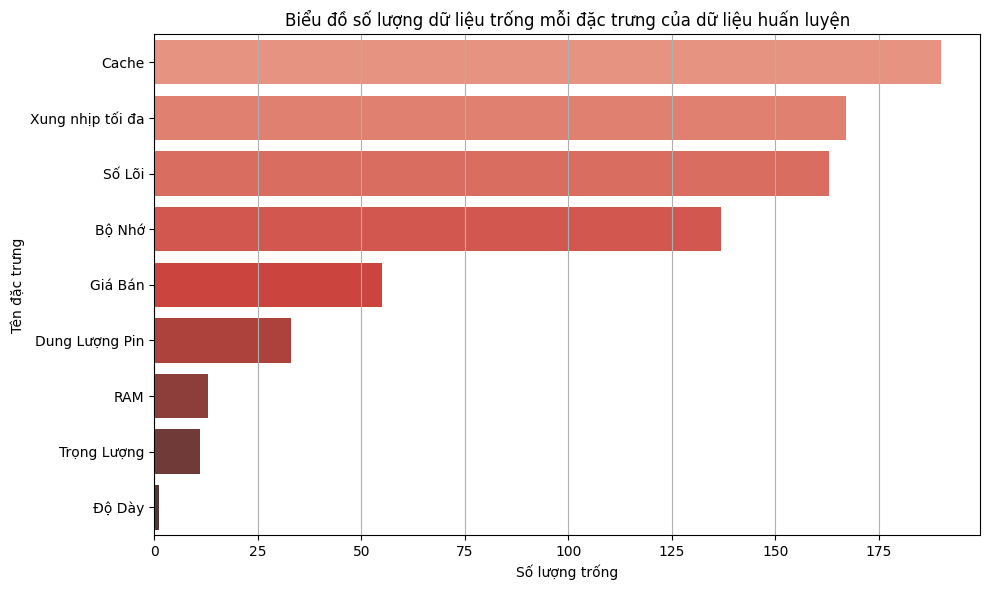

In [49]:
#Biểu diễn số dữ liệu trống mỗi đặc trưng dữ liệu huấn luyện
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def thong_ke_trong(df):
    missing_counts = df.isna().sum()
    missing_df = pd.DataFrame({
        'Đặc trưng': missing_counts.index,
        'Số lượng trống': missing_counts.values,
        'Tỷ lệ trống (%)': (missing_counts.values / len(df)) * 100
    })
    missing_df = missing_df[missing_df['Số lượng trống'] > 0]
    missing_df = missing_df.sort_values(by='Số lượng trống', ascending=False).reset_index(drop=True)
    return missing_df

# Thống kê dữ liệu trống
missing_df = thong_ke_trong(df3)

# Trực quan hóa nếu có dữ liệu trống
if not missing_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=missing_df, x='Số lượng trống', y='Đặc trưng', palette='Reds_d')
    plt.title('Biểu đồ số lượng dữ liệu trống mỗi đặc trưng của dữ liệu huấn luyện')
    plt.xlabel('Số lượng trống')
    plt.ylabel('Tên đặc trưng')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu bị thiếu trong tập dữ liệu.")


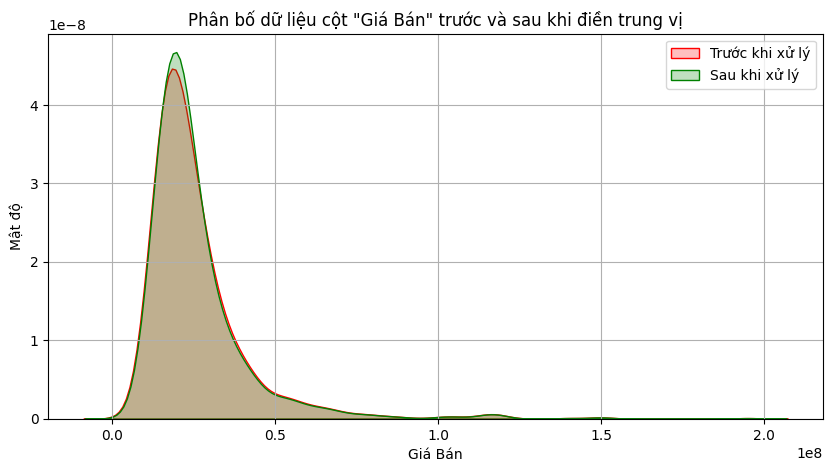

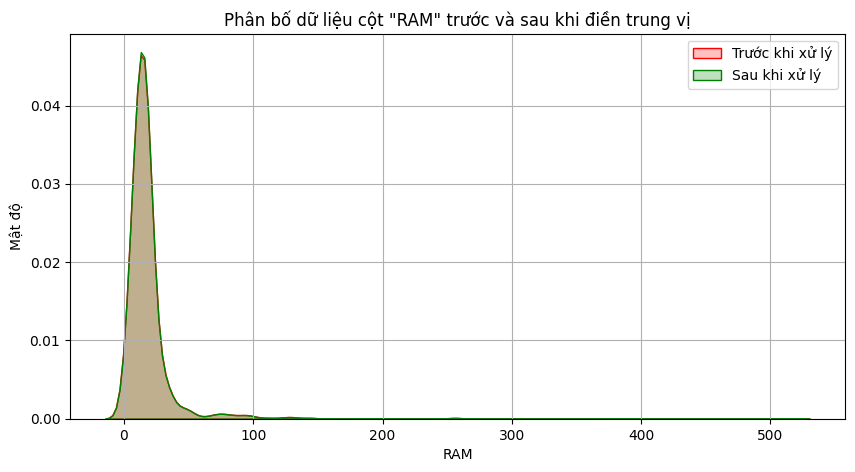

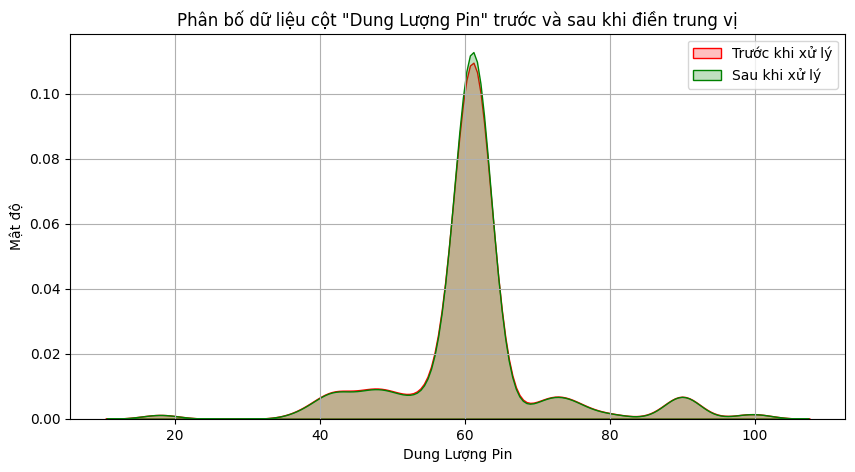

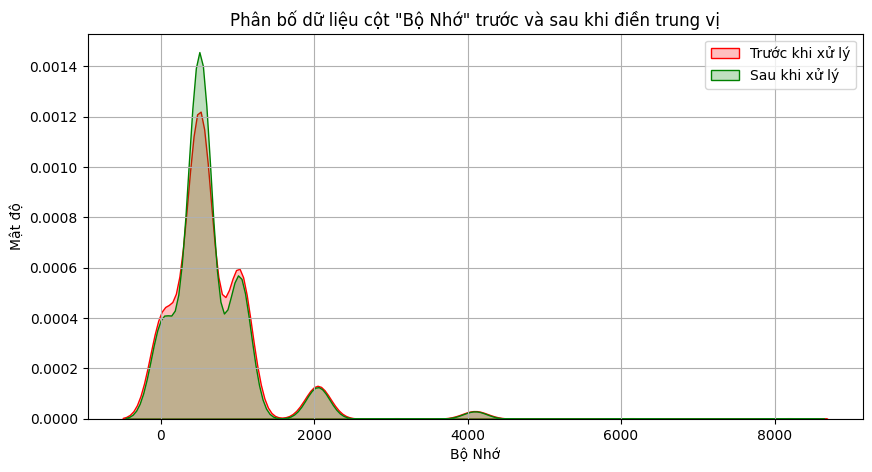

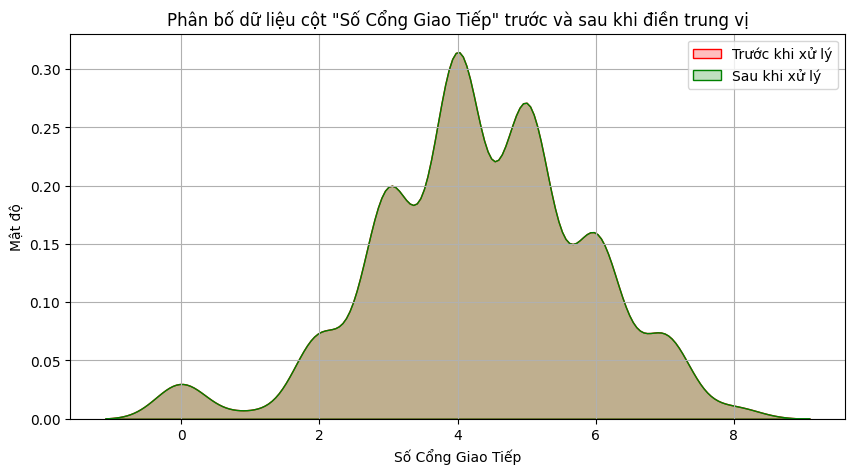

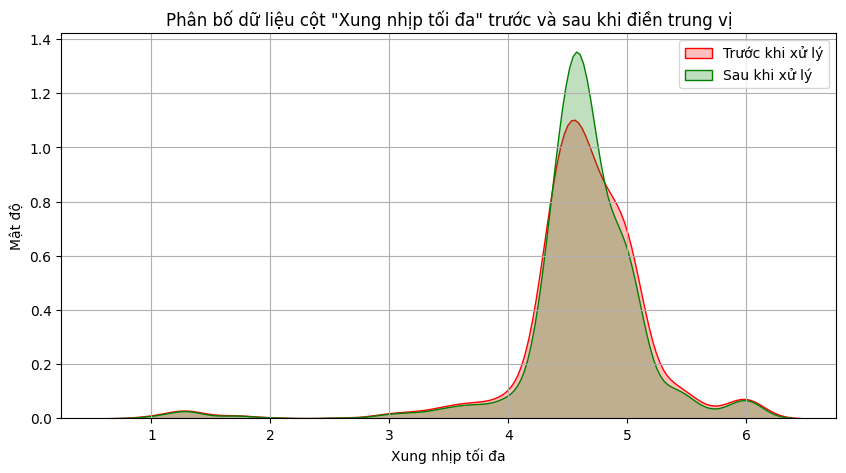

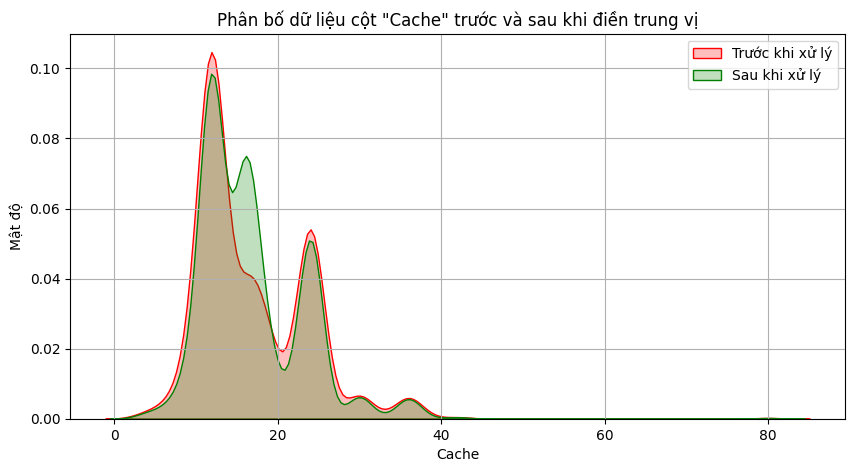

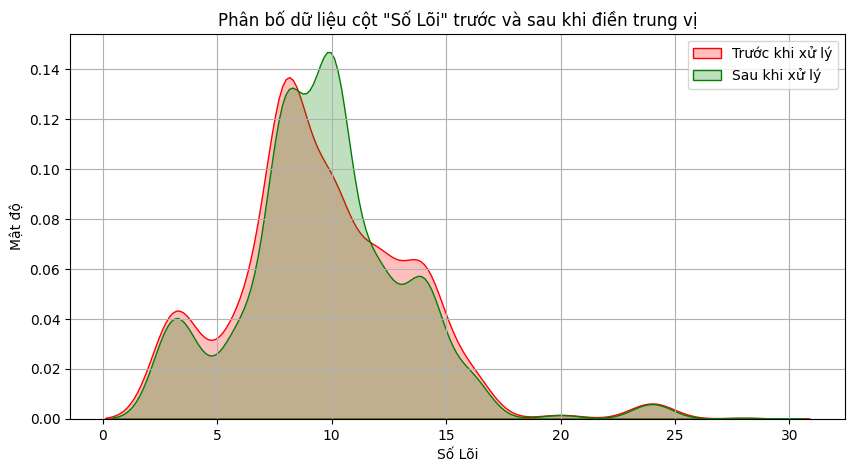

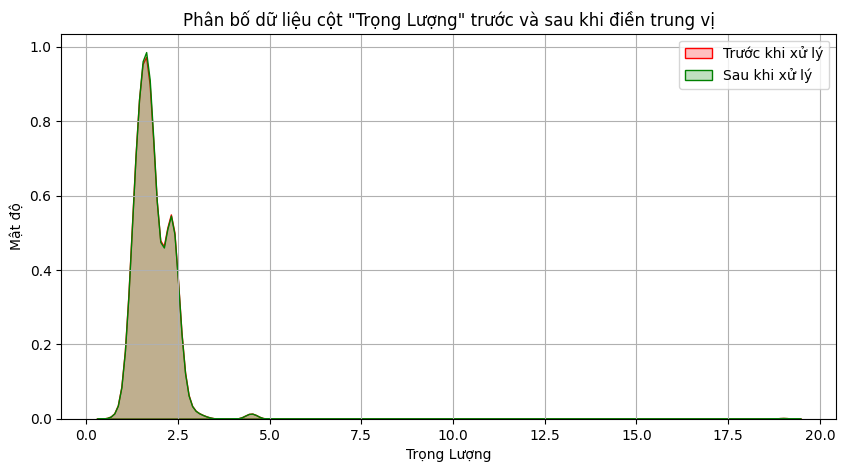

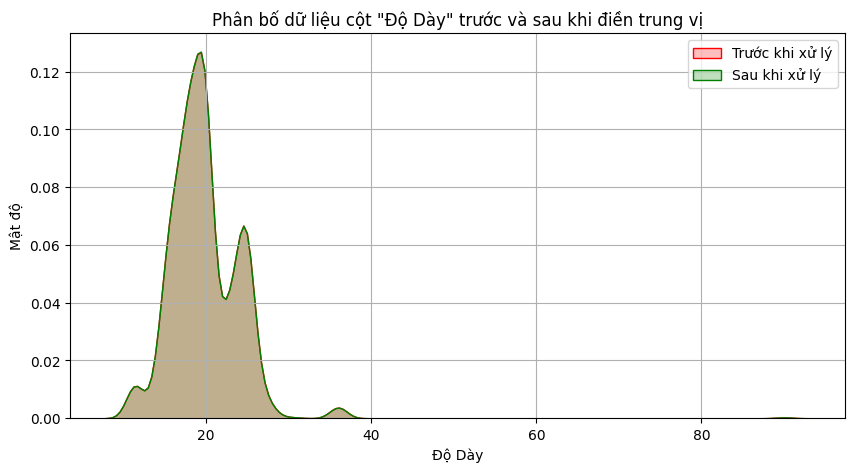

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Danh sách các cột số cần xử lý
numeric_columns = ['Giá Bán','RAM', 'Dung Lượng Pin', 'Bộ Nhớ', 'Số Cổng Giao Tiếp','Xung nhịp tối đa',
                   'Cache','Số Lõi','Trọng Lượng','Độ Dày']

# Tạo bản sao trước khi xử lý để so sánh
df_before = df[numeric_columns].copy()

# Điền giá trị thiếu bằng trung vị
for col in numeric_columns:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

# Tạo bản sau khi xử lý
df_after = df[numeric_columns]

# Trực quan hóa: Biểu đồ phân phối trước và sau xử lý
for col in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(df_before[col], label='Trước khi xử lý', color='red', fill=True)
    sns.kdeplot(df_after[col], label='Sau khi xử lý', color='green', fill=True)
    plt.title(f'Phân bố dữ liệu cột "{col}" trước và sau khi điền trung vị')
    plt.xlabel(col)
    plt.ylabel('Mật độ')
    plt.legend()
    plt.grid(True)
    plt.show()


In [51]:
# Lấp giá trị thiếu với giá trị phổ biến nhất cho các cột phân loại
categorical_columns = ['Hệ Điều Hành', 'Loại Màn Hình','Hãng CPU',  'Hãng GPU','Độ Phân Giải','Hãng Sản Xuất']
for col in categorical_columns:
    df[col].fillna(df3[col].mode()[0], inplace=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_916\689445961.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df3[col].mode()[0], inplace=True)


In [52]:
def classify_usage(row):
    name = str(row['Tên Sản Phẩm']).lower()
    cpu_brand = str(row['Hãng CPU']).lower()
    gpu_brand = str(row['Hãng GPU']).lower()
    screen_type = str(row['Loại Màn Hình']).lower()
    resolution = row['Độ Phân Giải']
    weight = row['Trọng Lượng']
    thickness = row['Độ Dày']
    
    try:
        cores = int(row['Số Lõi'])
    except:
        cores = 0

    # 1. Laptop 2-trong-1 / Cảm ứng
    if any(k in name for k in ['x360', 'flip', 'cảm ứng', 'touch']):
        return 'Laptop 2 trong 1 / Cảm ứng'

    # 2. Gaming
    if ('rog' in name or 'tuf' in name or 'gaming' in name or 'predator' in name ):
        return 'Gaming'

    # 3. Thiết kế đồ họa / Multimedia
    high_res = False
    if isinstance(resolution, str) and 'x' in resolution:
        try:
            width = int(resolution.split('x')[0])
            if width >= 2560:
                high_res = True
        except:
            pass
    if ('creator' in name or 'studio' in name or 'pro' in name or
        screen_type in ['oled', 'led', 'retina'] or high_res):
        return 'Thiết kế đồ họa / Multimedia'

    # 4. Di động / Mỏng nhẹ / Ultrabook
    thin = not pd.isna(thickness) and float(thickness) < 18
    light = not pd.isna(weight) and float(weight) < 1.5
    if thin or light or any(k in name for k in ['zenbook', 'air', 'ultrabook']):
        return 'Di động / Mỏng nhẹ / Ultrabook'

    # 5. Kỹ thuật / Lập trình
    if cores >= 8:
        return 'Kỹ thuật / Lập trình'

    # 6. Mặc định
    return 'Văn phòng / Học tập'

df['Phân Loại'] = df.apply(classify_usage, axis=1)
phanloai = df['Phân Loại'].unique()
for i in phanloai:
    count = (df['Phân Loại'] == i).sum()
    print(f"• {i}: {count} máy")


• Di động / Mỏng nhẹ / Ultrabook: 322 máy
• Kỹ thuật / Lập trình: 269 máy
• Văn phòng / Học tập: 67 máy
• Thiết kế đồ họa / Multimedia: 297 máy
• Gaming: 222 máy
• Laptop 2 trong 1 / Cảm ứng: 66 máy


In [53]:
df.drop('Tên Sản Phẩm', axis=1, inplace=True)
df.drop('CPU', axis=1, inplace=True)
df.drop('GPU', axis=1, inplace=True)
df.drop('Màn Hình', axis=1, inplace=True)

In [54]:
# Xuất dữ liệu đã làm sạch
df.to_csv("../clean_data_train/filled_data.csv", index=False)

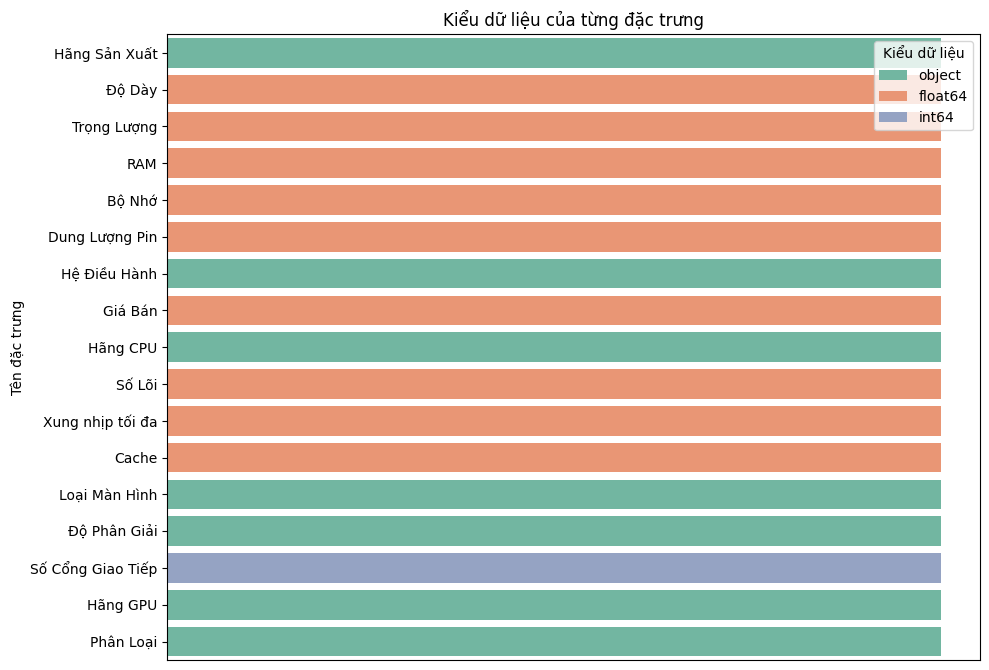

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo DataFrame chứa tên cột và kiểu dữ liệu dạng chuỗi
dtype_df = pd.DataFrame({
    'Đặc trưng': df.columns,
    'Kiểu dữ liệu': df.dtypes.astype(str).values
})

# Vẽ biểu đồ cột ngang hiển thị kiểu dữ liệu theo từng đặc trưng
plt.figure(figsize=(10, len(dtype_df) * 0.4))
sns.barplot(
    x=[1] * len(dtype_df),  # tất cả có giá trị 1 để tạo chiều dài bằng nhau
    y='Đặc trưng',
    hue='Kiểu dữ liệu',
    data=dtype_df,
    dodge=False,
    palette='Set2'
)

plt.title('Kiểu dữ liệu của từng đặc trưng')
plt.xlabel('')
plt.ylabel('Tên đặc trưng')
plt.xticks([])
plt.legend(title='Kiểu dữ liệu')
plt.tight_layout()
plt.show()


In [56]:
#Chuẩn hóa về dạng phân phối chuẩn
from sklearn.preprocessing import StandardScaler

# Danh sách các cột cần chuẩn hóa
numerical_cols = ['RAM', 'Dung Lượng Pin', 'Bộ Nhớ', 'Số Cổng Giao Tiếp','Xung nhịp tối đa','Cache','Số Lõi','Giá Bán','Trọng Lượng','Độ Dày']

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [57]:

# Mã hóa các nhãn danh mục
from sklearn.preprocessing import LabelEncoder
categorical_cols = ['Hệ Điều Hành', 'Loại Màn Hình', 'Hãng CPU',  'Hãng GPU','Độ Phân Giải','Hãng Sản Xuất']

# Áp dụng LabelEncoder cho từng cột
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

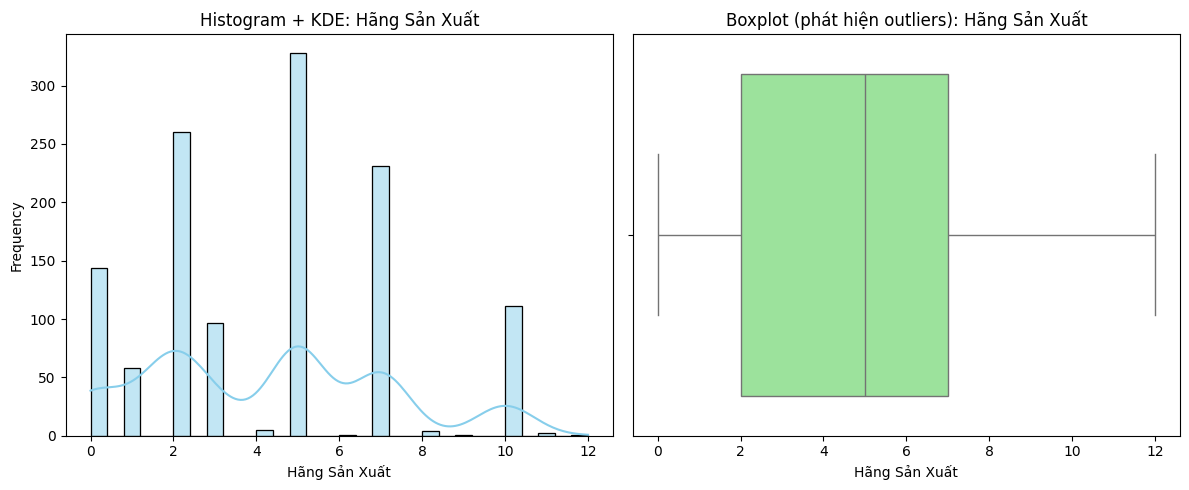

Số điểm nghi ngờ outlier theo Z-score (>3): 0




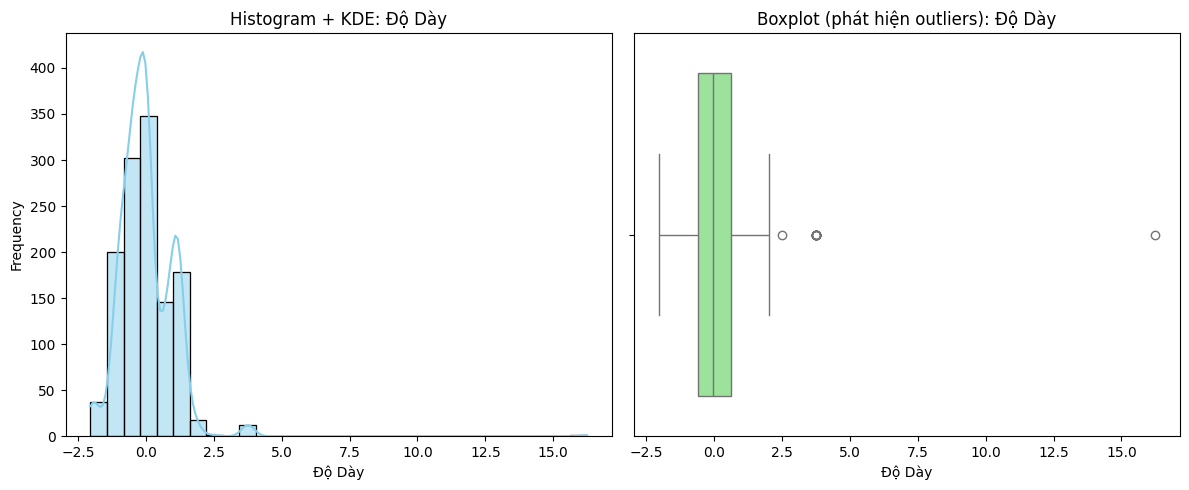

Số điểm nghi ngờ outlier theo Z-score (>3): 13




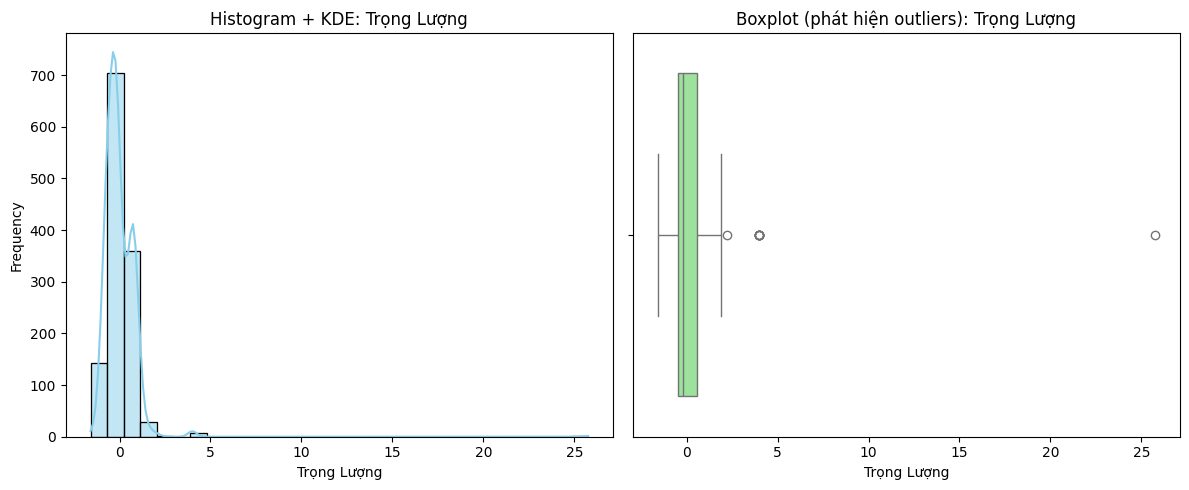

Số điểm nghi ngờ outlier theo Z-score (>3): 8




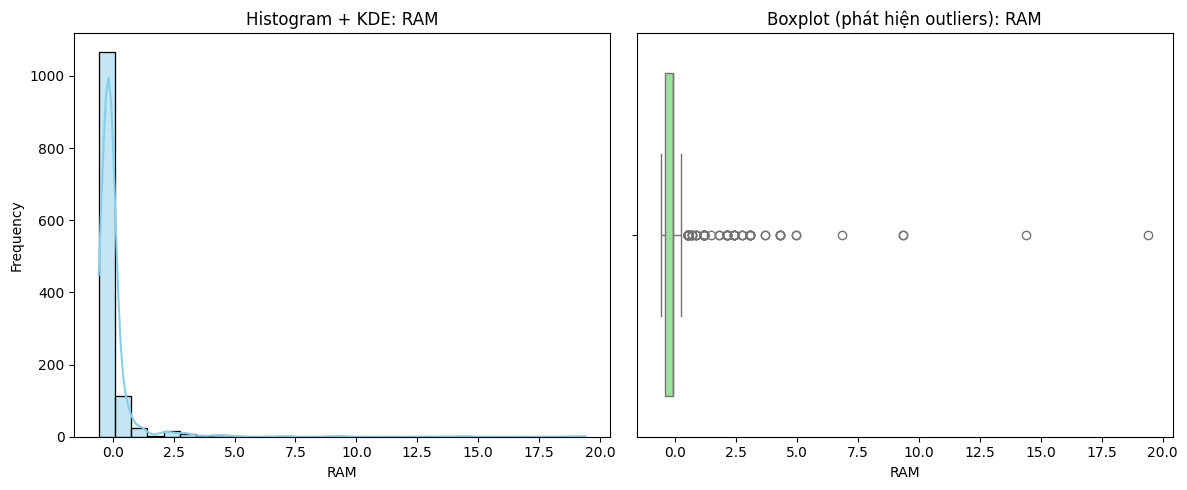

Số điểm nghi ngờ outlier theo Z-score (>3): 20




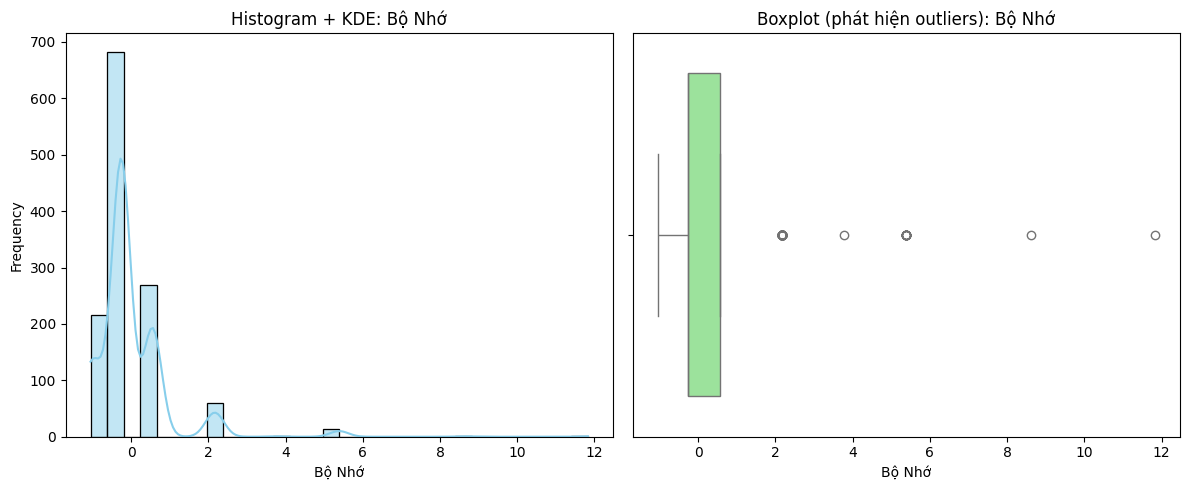

Số điểm nghi ngờ outlier theo Z-score (>3): 17




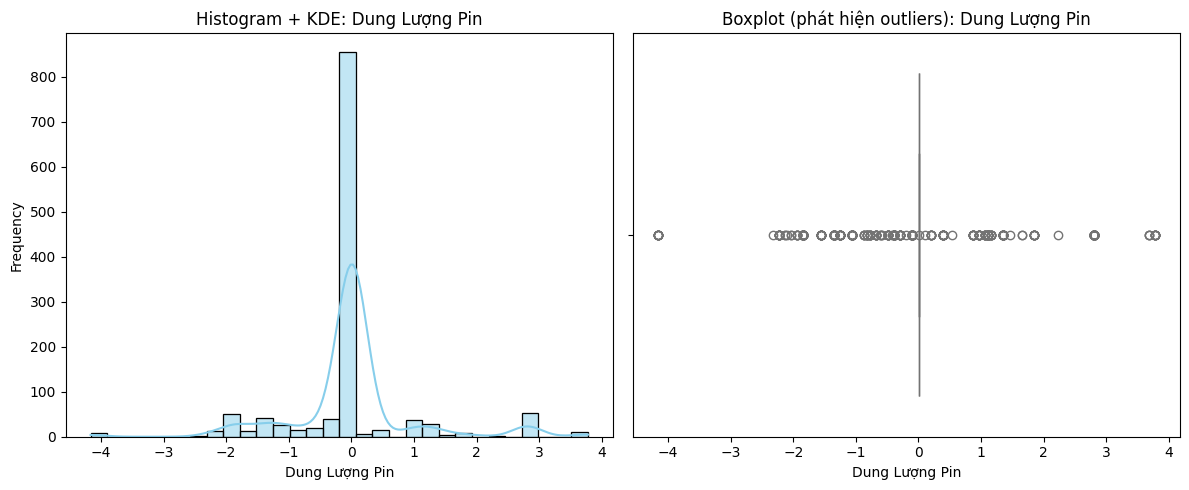

Số điểm nghi ngờ outlier theo Z-score (>3): 11




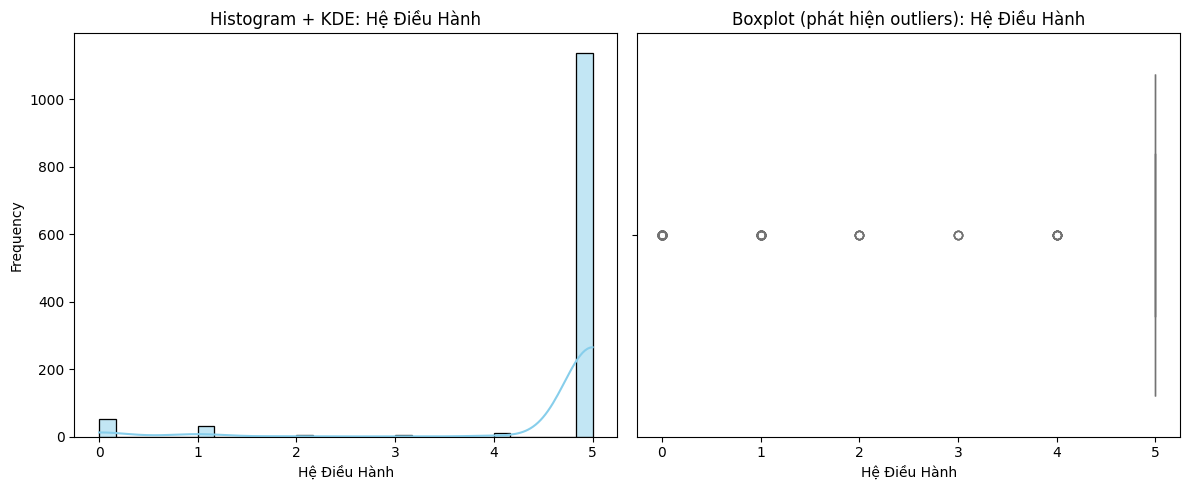

Số điểm nghi ngờ outlier theo Z-score (>3): 0




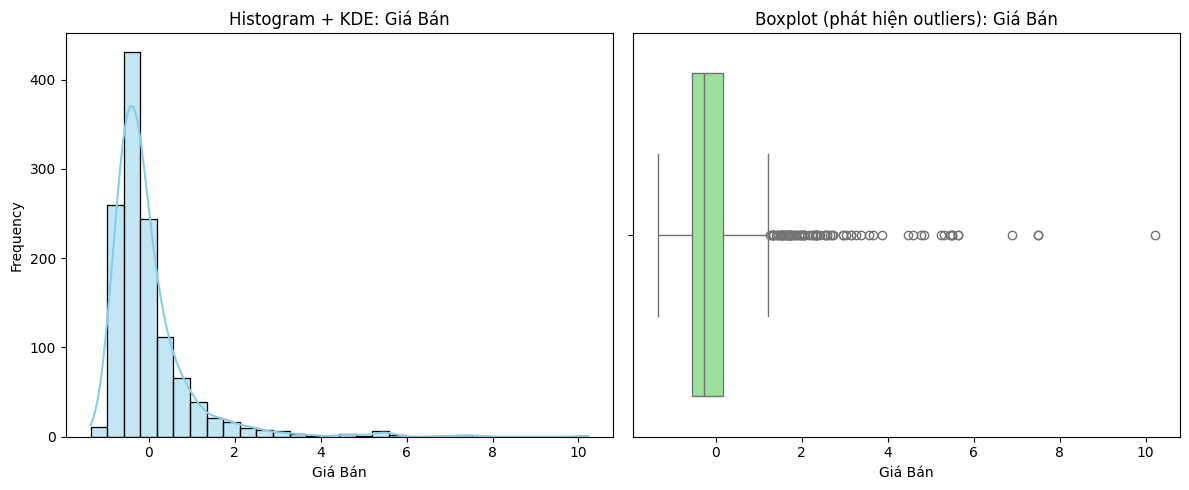

Số điểm nghi ngờ outlier theo Z-score (>3): 24




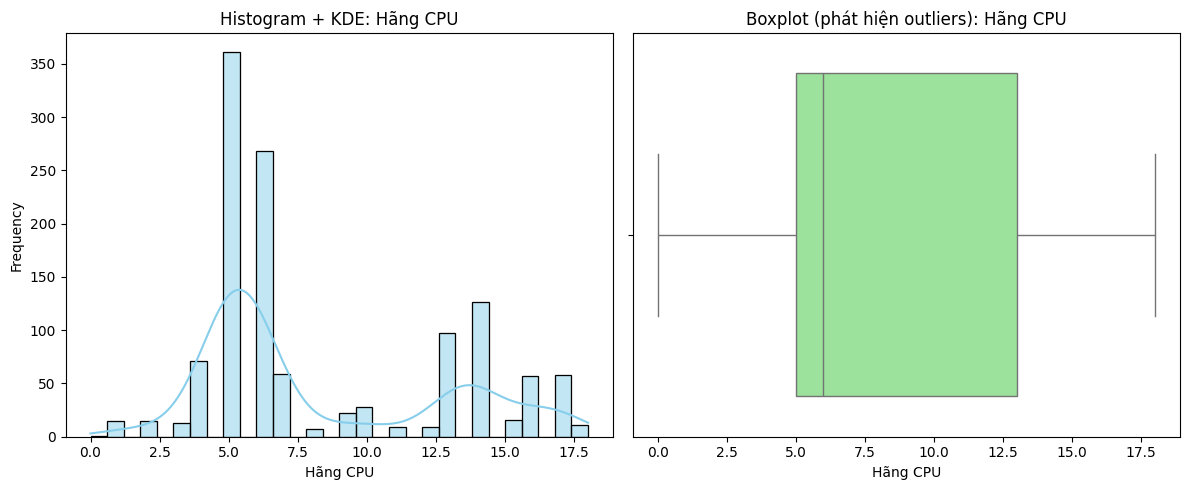

Số điểm nghi ngờ outlier theo Z-score (>3): 0




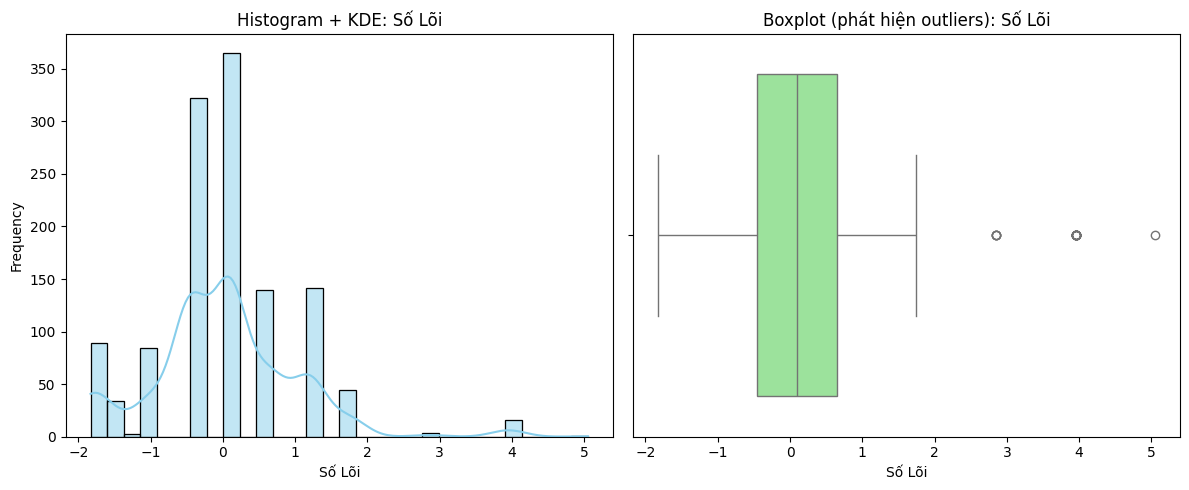

Số điểm nghi ngờ outlier theo Z-score (>3): 17




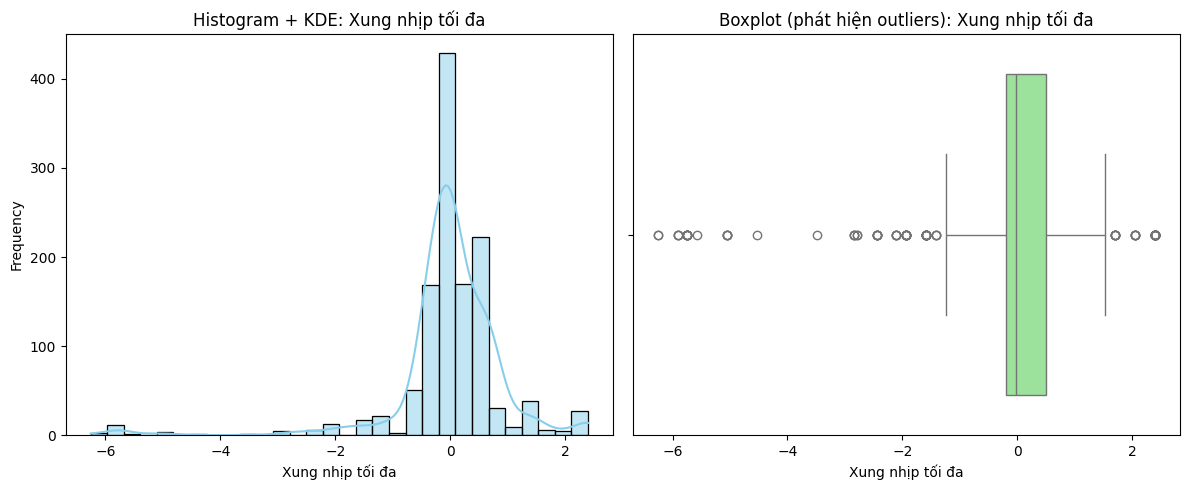

Số điểm nghi ngờ outlier theo Z-score (>3): 0




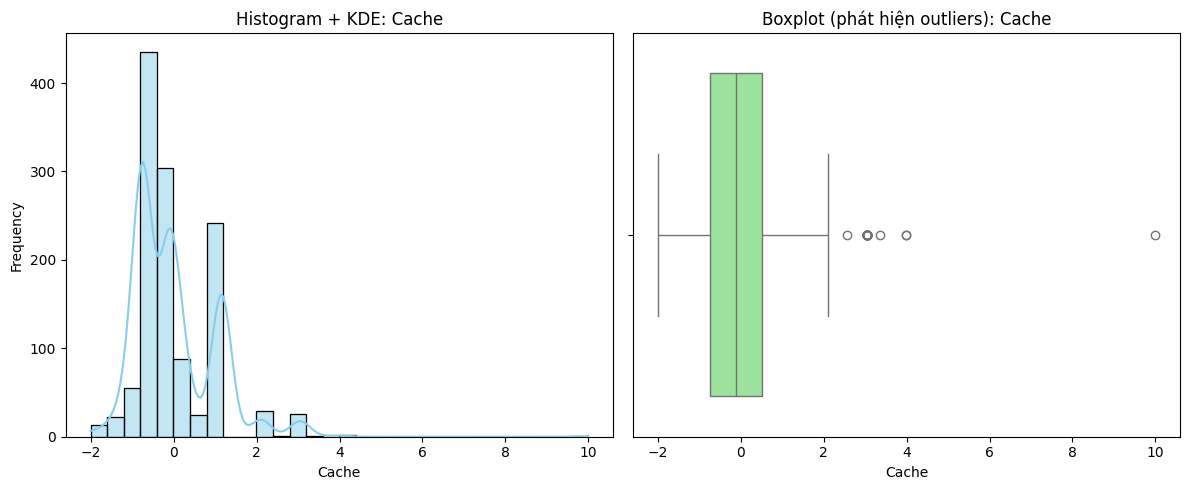

Số điểm nghi ngờ outlier theo Z-score (>3): 30




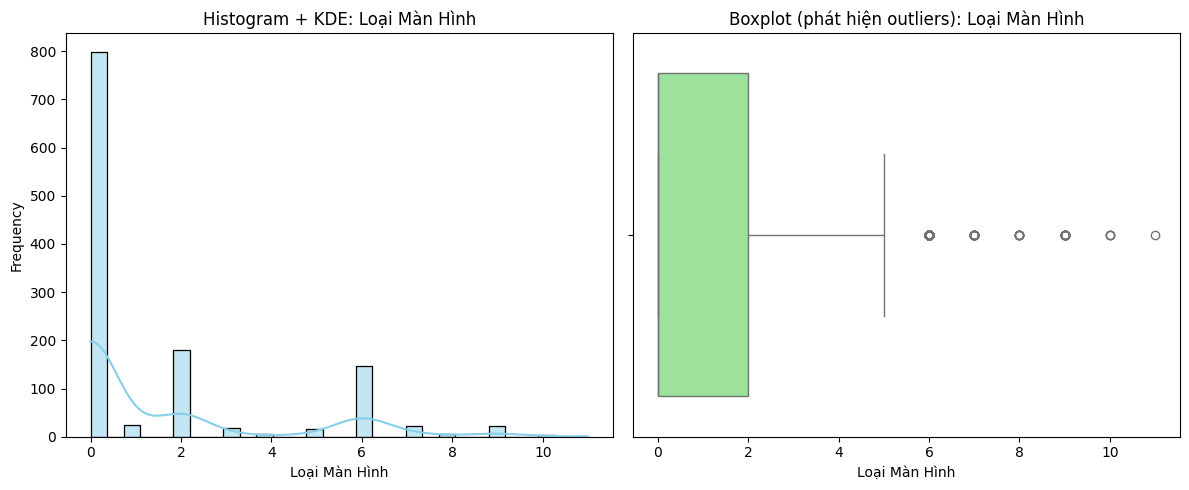

Số điểm nghi ngờ outlier theo Z-score (>3): 27




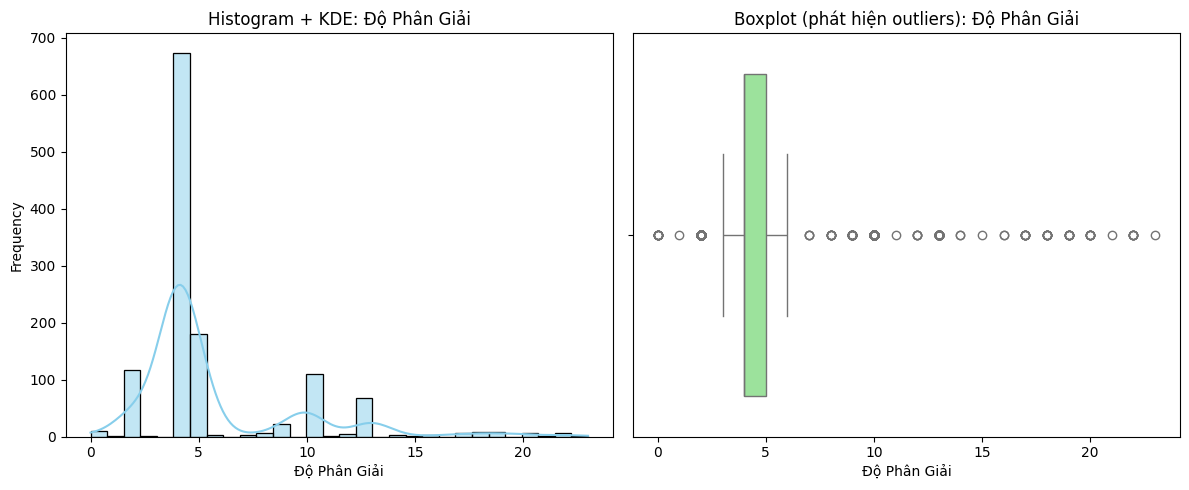

Số điểm nghi ngờ outlier theo Z-score (>3): 38




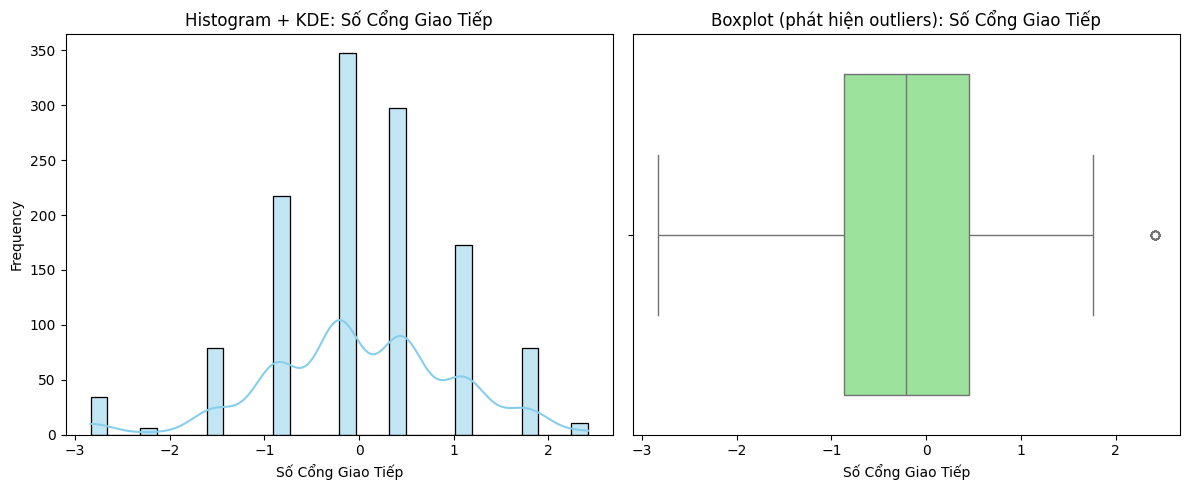

Số điểm nghi ngờ outlier theo Z-score (>3): 0




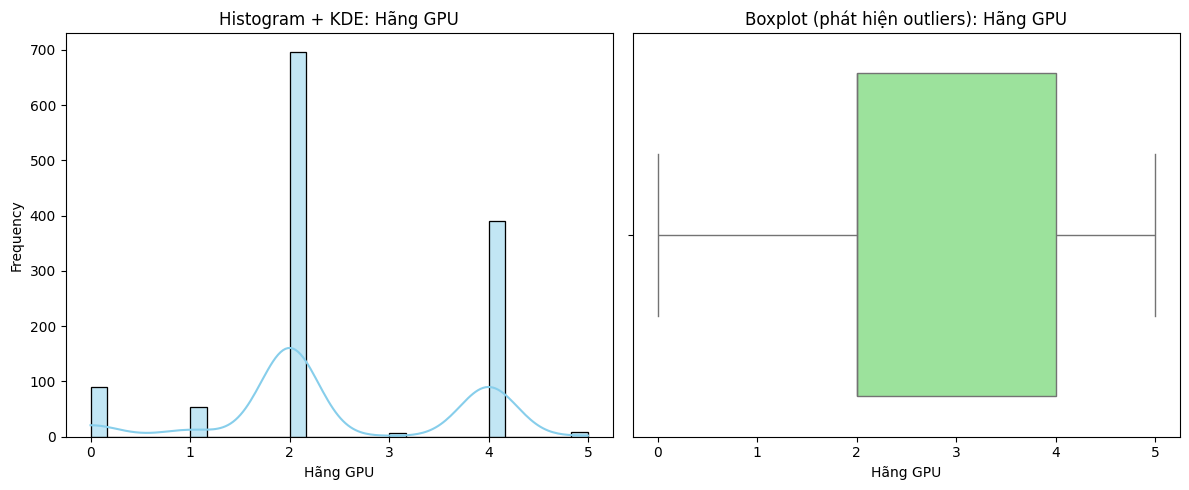

Số điểm nghi ngờ outlier theo Z-score (>3): 0




In [58]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

# Lấy các cột số
numeric_cols = df.select_dtypes(include='number').columns

for col in numeric_cols:
    # Histogram + KDE
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'Histogram + KDE: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    # Boxplot để phát hiện outliers trực quan
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot (phát hiện outliers): {col}')
    
    plt.tight_layout()
    plt.show()
    
    # Phát hiện outliers bằng Z-score (chỉ trên giá trị không bị thiếu)
    non_na_series = df[col].dropna()
    z_scores = zscore(non_na_series)

    # Lấy index các outlier
    outlier_idx = non_na_series.index[z_scores > 3]

    # Trích xuất outlier từ df theo chỉ số gốc
    outliers_z = df.loc[outlier_idx, col]

    print(f"Số điểm nghi ngờ outlier theo Z-score (>3): {len(outliers_z)}")
    print("\n")


In [59]:
#Loại bỏ outliers data train
from scipy.stats import zscore
import numpy as np

# Tính Z-score cho tất cả các cột số
z_scores = np.abs(zscore(df[numeric_cols], nan_policy='omit'))

# Tạo mask: mỗi dòng có bất kỳ giá trị Z-score > ngưỡng nào hay không (ví dụ: > 3)
threshold = 3
rows_with_outliers = (z_scores > threshold).any(axis=1)

# Loại bỏ các dòng có outlier
train_df_cleaned = df[~rows_with_outliers].copy()


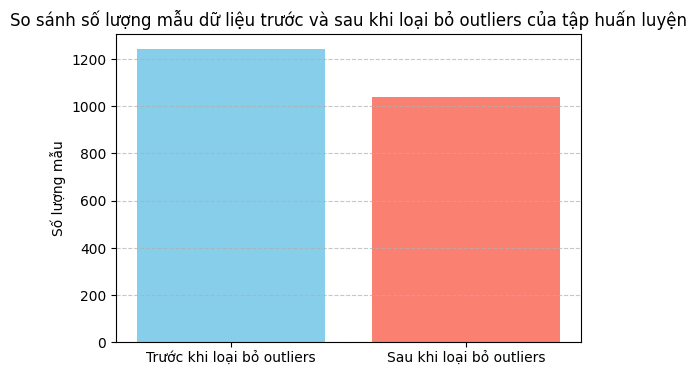

In [60]:
import matplotlib.pyplot as plt

# Số mẫu trước và sau khi loại bỏ outliers của data train
counts = {
    'Trước khi loại bỏ outliers': len(df),
    'Sau khi loại bỏ outliers': len(train_df_cleaned)
}

plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values(), color=['skyblue', 'salmon'])
plt.title('So sánh số lượng mẫu dữ liệu trước và sau khi loại bỏ outliers của tập huấn luyện')
plt.ylabel('Số lượng mẫu')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [61]:
df.to_csv("../clean_data_train/encoded_data.csv", index=False)